<a href="https://colab.research.google.com/github/snel-repo/ComputationThruDynamicsBenchmark/blob/main/examples/WorkshopNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import random
import dotenv
import pathlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch
#import plotly.figure_factory as ff
#import plotly.graph_objects as go

#from torchviz import make_dot

random.seed(2024)
dotenv.load_dotenv(override=True)

HOME_DIR = os.getenv("HOME_DIR")

from ctd.comparison.analysis.tt.tt import Analysis_TT

## CDM Task

There are four modes implemented in CtD under the MultiTask class. From Driscoll et al.: Move in direction of stimulus with largest amplitude. IntegrationModality1: Only modality 1 is presented. IntegrationModality2: Only modality 2 is presented. ContextInt Modality1: Both modalities presented, only attend modality 1. ContextIntModality2: Both modalities presented, only attend modality 2. IntegrationMultimodal: Both modalities presented, attend both mo
dalities equally.

#### Note that the trial lengths are uniformly random: 

* In CtD the total time is different in between trials, and time of the different stimulus/memory/response periods is also different

* But surely the Driscoll RNN architecture should solve this?? They use batch size (mini batch) of 64 trials (each batch from one task - so only ContextIntMod1, ContextIntMod2, etc), lr = 1e-4 for tanh, weight decay 0.9 for L1 and 0.999 for L2. Needed 50 million training steps (!!??)

* They implement a mask in the multitask loss: 


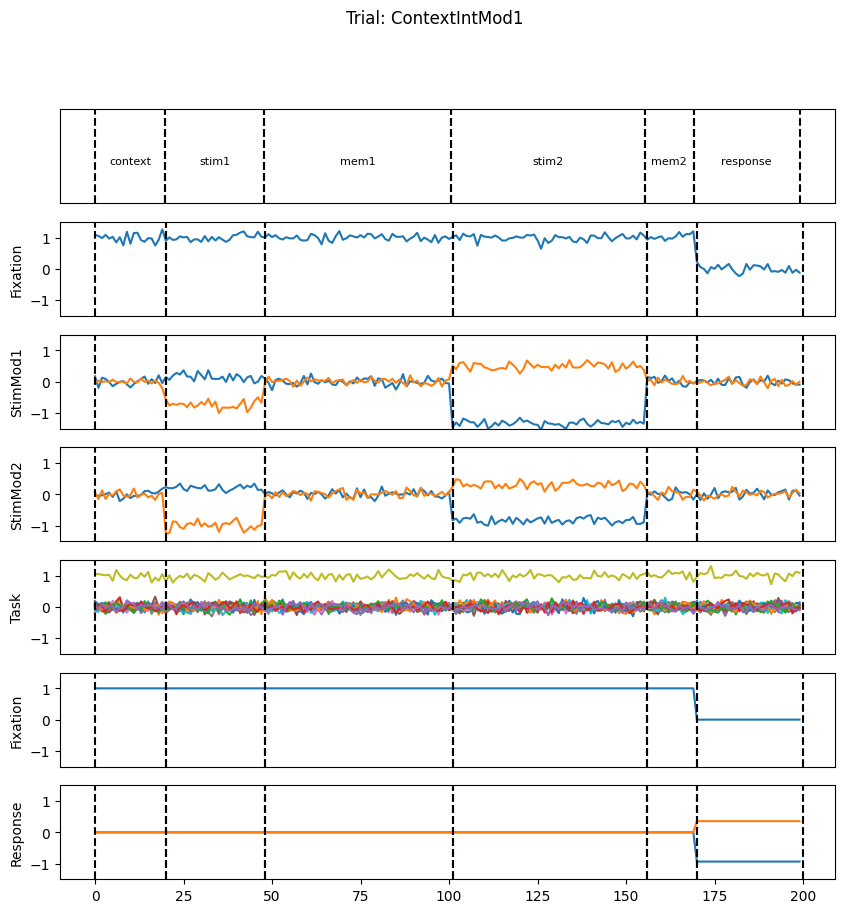

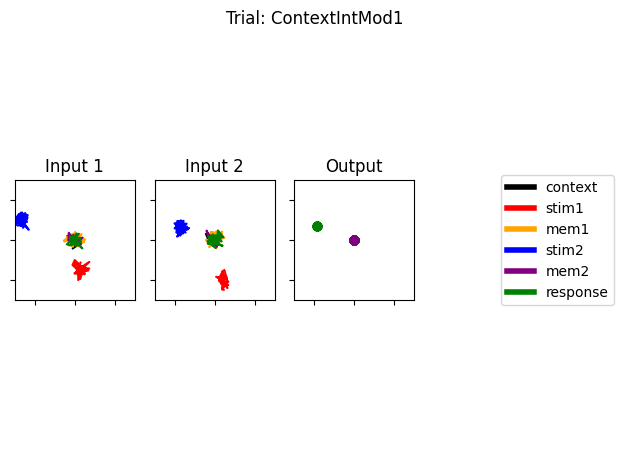

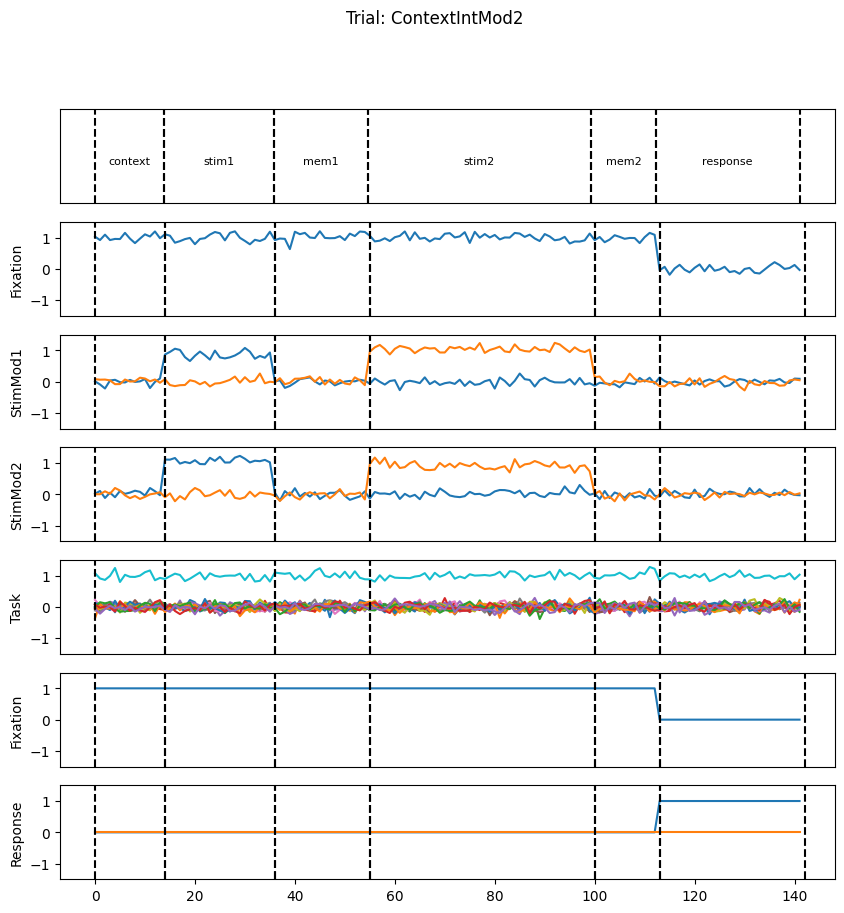

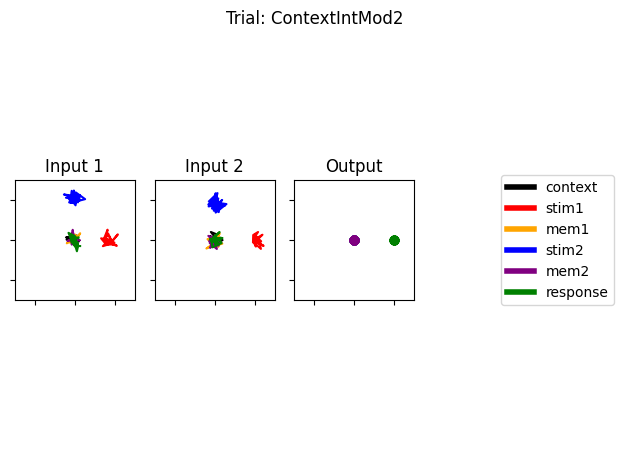

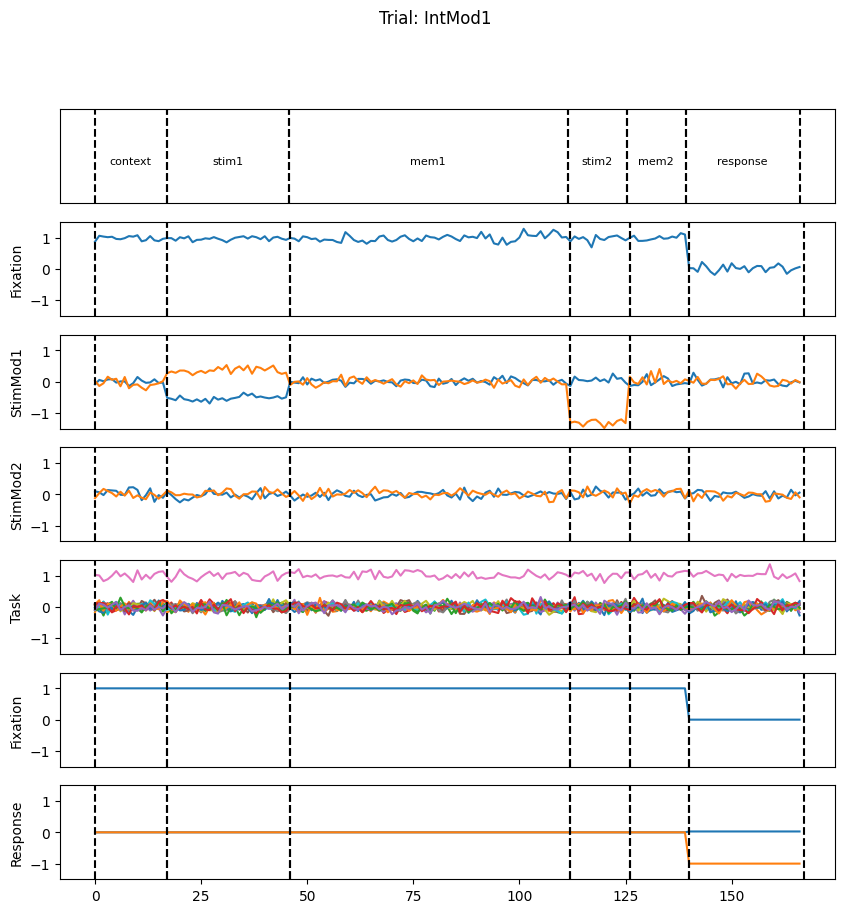

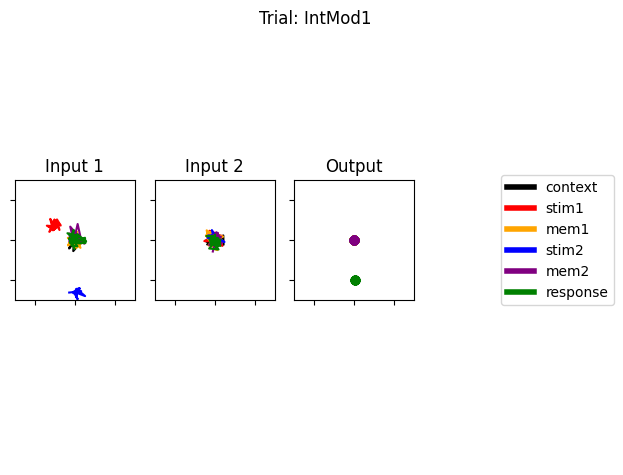

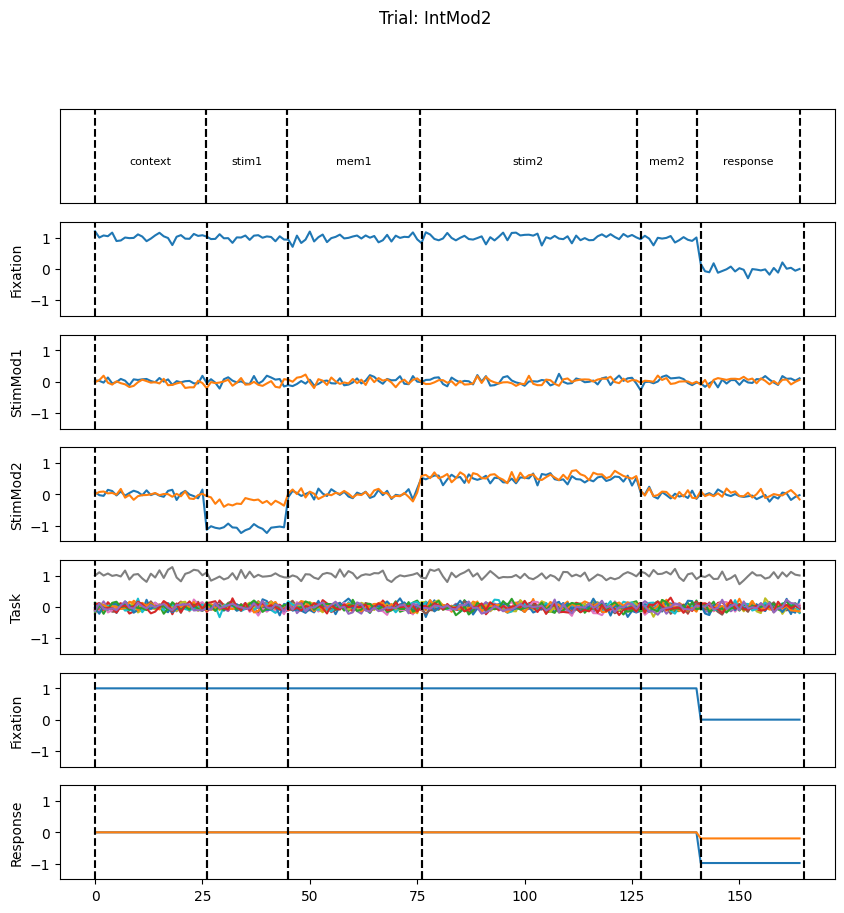

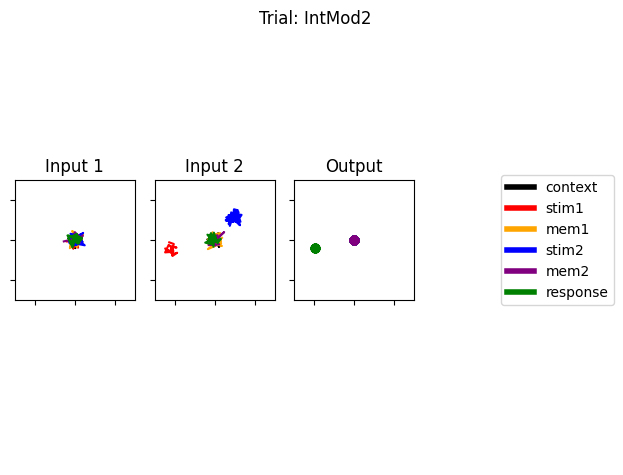

In [3]:
from ctd.task_modeling.task_env.multitask import MultiTask

# same parameters as those I use in the first training (naive) round of nodes and gnodes
CDM1c = MultiTask(task_name="ContextIntMod1",
                 bin_size=20,
                 num_targets=32,
                 noise=0.1,)
CDM2c = MultiTask(task_name="ContextIntMod2",
                 bin_size=20,
                 num_targets=32,
                 noise=0.1,)
CDM1 = MultiTask(task_name="IntMod1",
                 bin_size=20,
                 num_targets=32,
                 noise=0.1,)
CDM2 = MultiTask(task_name="IntMod2",
                 bin_size=20,
                 num_targets=32,
                 noise=0.1,)

CDM1c.plot_trial()
CDM2c.plot_trial()
CDM1.plot_trial()
CDM2.plot_trial()

## ContextIntMod1: NODE

* latent size = 2
* weight decay 1e-9
* learning rate 5e-3
* 5 epochs (300 running)
* n=20 (average pulses in trial)

Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


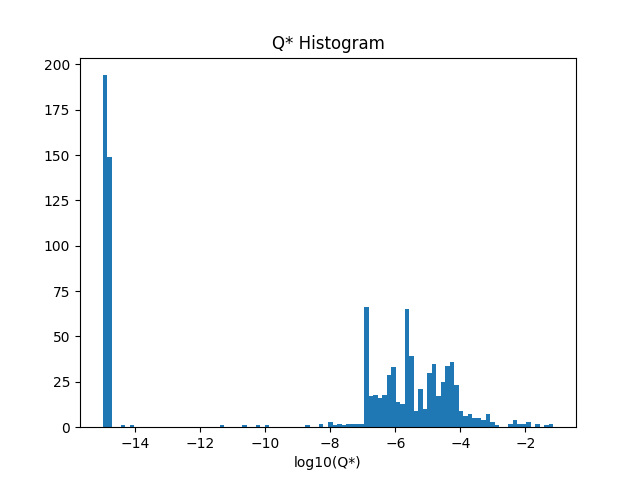

<IPython.core.display.Javascript object>


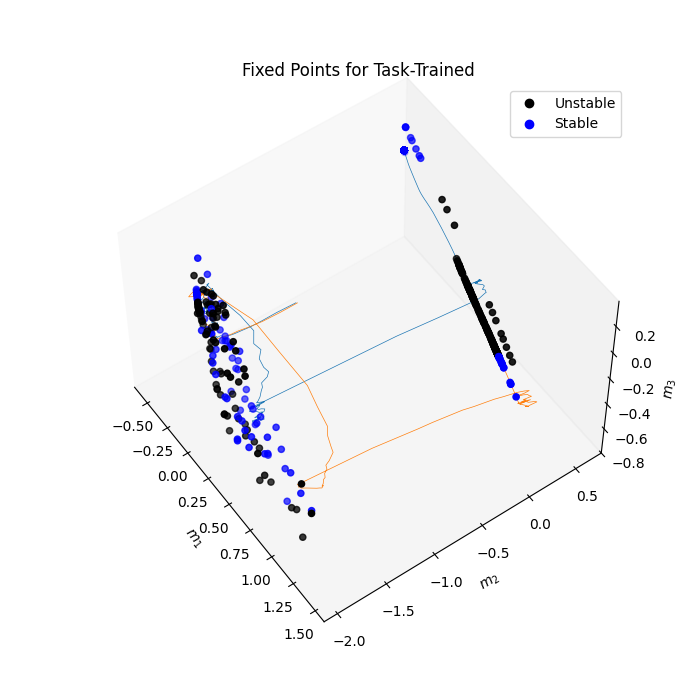

In [3]:
path = "/scratch/gpfs/ad2002/content/trained_models/task-trained/20240710_NODE_MultiTask_CDM_5epoch/latent_size=3 weight_decay=1e-09 learning_rate=0.01 max_epochs=5 log_every_n_steps=25 seed=0 batch_size=32 n_samples=800 task_list=['ContextIntMod1'] task_list=['ContextIntMod1']/"
node_CDM1 = Analysis_TT(run_name = "node_cdm1_mini", filepath = path, use_train_dm=False)

# TODO: fix whatever is wrong with saving the train datamodule (as opposed to the sim)

# INPUTS: you can pass your own into the FPF, but it should not have the same shape as the internal inputs used
# in the actual FPF algorithm. Shape should be (n_trials, n_timesteps, n_input_channels)
# To return the latter and plot the velocity field with the same internal inputs, set return_points=True

# Ex: you can pass in the zero inputs below, and it will return the internal inputs that the FPF has transformed
# inputs to accounting for time and total trials. 
# OR you can set inputs to None, and will return random inputs that the FPF internally used

%matplotlib notebook
my_inputs = 1*torch.ones_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

fps, xstar, q_flag, color = node_CDM1.plot_fps(
    inputs= None,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-5,   # higher rate gives less but actually accurate values - NOTE the right learning rate for 
                            # this finder seems to be similar to the optimal for the model training. not a coincidence....
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True, 
    num_traj=2
)

Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


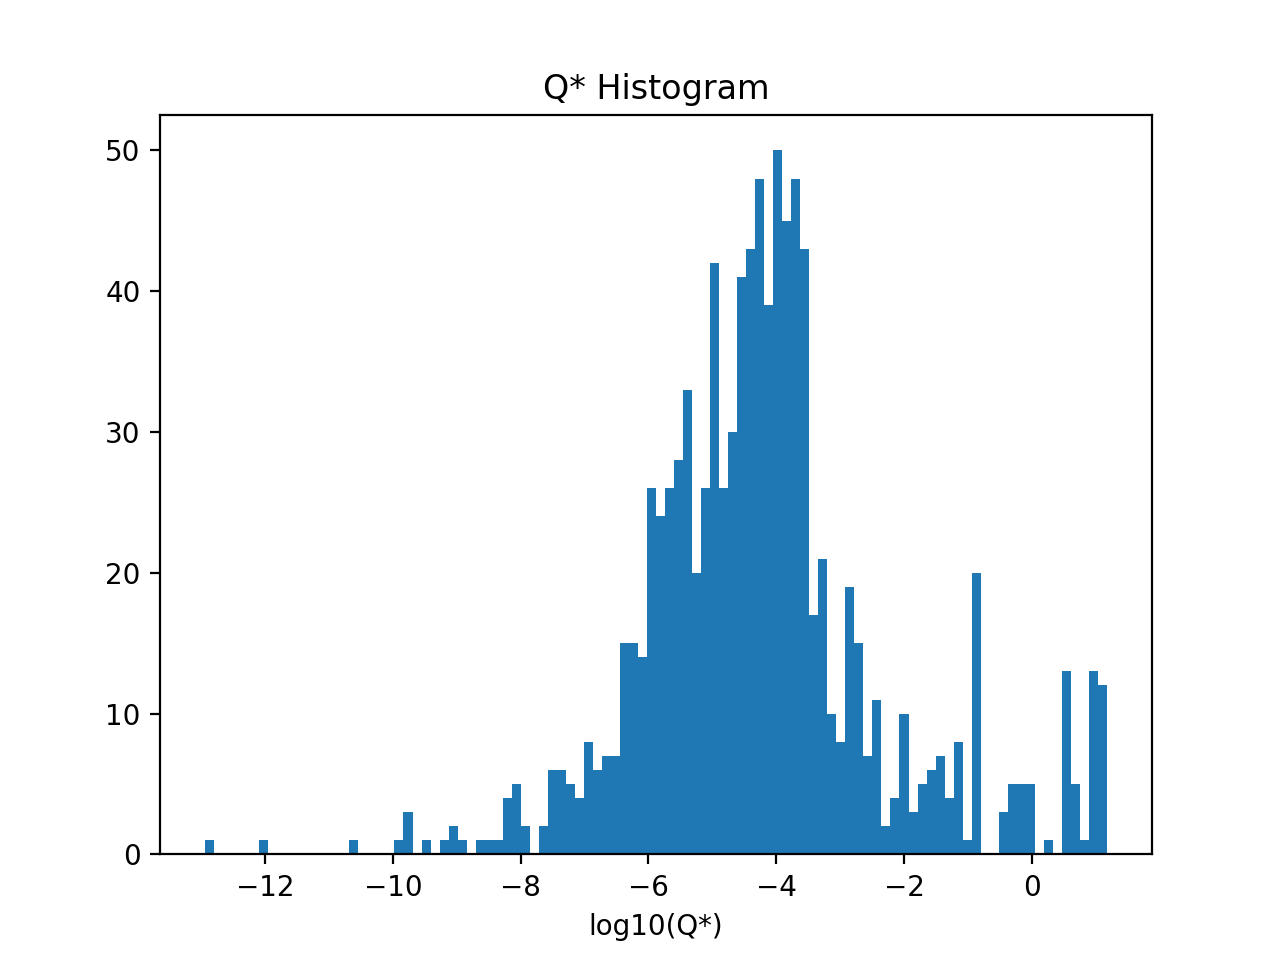

<IPython.core.display.Javascript object>


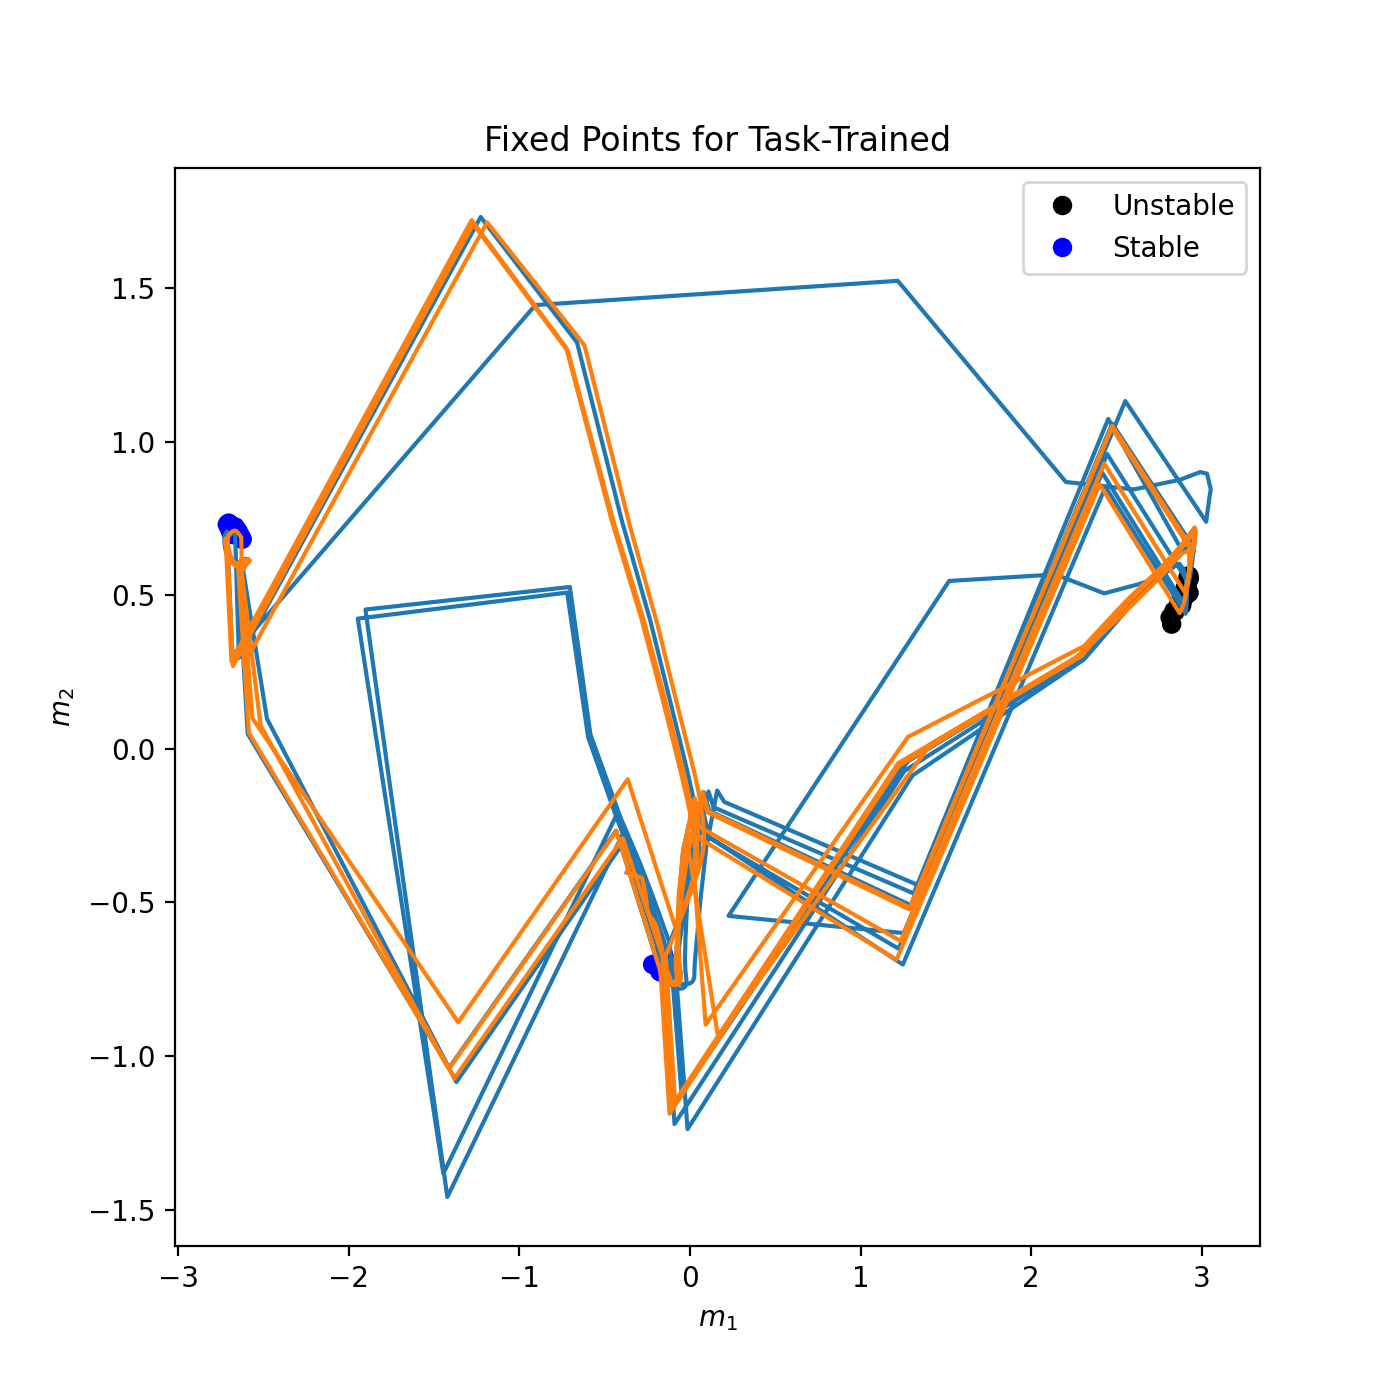

In [8]:
# compare to GRU PCA

# n = 20
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240424_GRU_OBS_200epoch_wpois/latent_size=128 weight_decay=1e-05 learning_rate=0.01 max_epochs=200 log_every_n_steps=2 seed=0 batch_size=264 num_workers=1 n_samples=500/"
GRU_OBS_2D = Analysis_TT(run_name = "node_obs_test", filepath = path)

%matplotlib notebook

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

fps_gru, xstar_gru, q_flag_gru, color_gru = GRU_OBS_2D.plot_fps(
    inputs= my_inputs,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-8,   # higher rate gives less but actually accurate values - NOTE the right learning rate for 
                            # this finder seems to be similar to the optimal for the model training. not a coincidence....
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = True,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True,
    num_traj = 2
)



Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


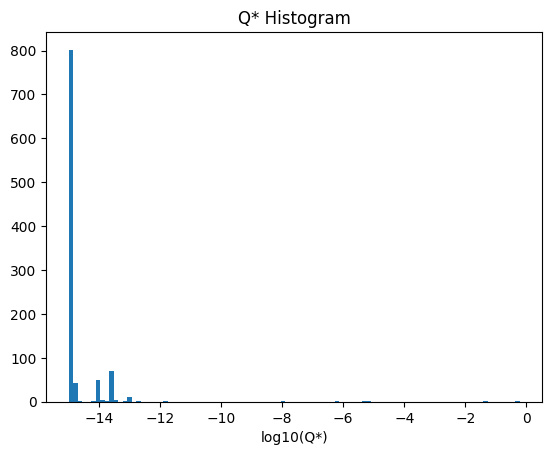

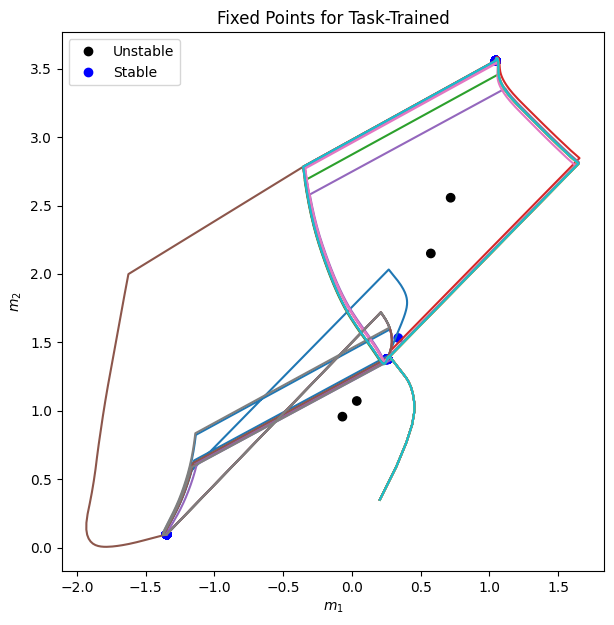

In [21]:
# n = 5
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240426_NODE_OBS_300epoch/latent_size=2 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.001 max_epochs=300 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500 n=5 n=5/"
node_OBS_2D_5= Analysis_TT(run_name = "node_obs_test", filepath = path)

# INPUTS: you can pass your own into the FPF, but it should not have the same shape as the internal inputs used
# in the actual FPF algorithm. Shape should be (n_trials, n_timesteps, n_input_channels)
# To return the latter and plot the velocity field with the same internal inputs, set return_points=True

# Ex: you can pass in the zero inputs below, and it will return the internal inputs that the FPF has transformed
# inputs to accounting for time and total trials. 
# OR you can set inputs to None, and will return random inputs that the FPF internally used

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

fps_5, xstar_5, q_flag_5, color_5 = node_OBS_2D_5.plot_fps(
    inputs= None,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-2,   # higher rate gives less but actually accurate values - NOTE the right learning rate for 
                            # this finder seems to be similar to the optimal for the model training. not a coincidence....
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)



Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


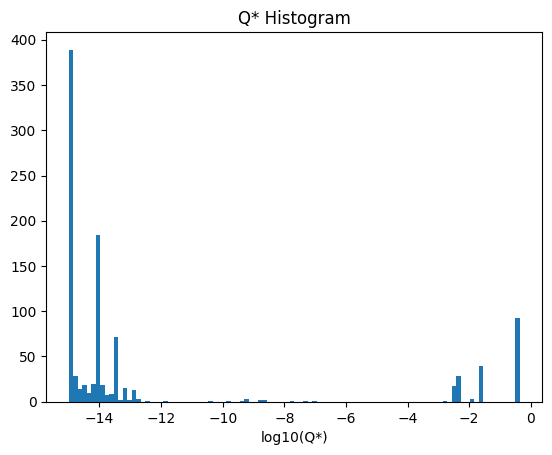

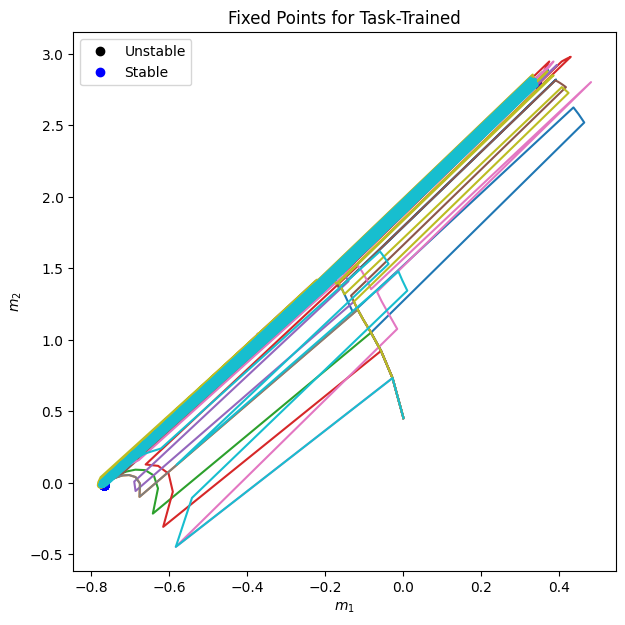

In [22]:
# n = 200
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240426_NODE_OBS_300epoch/latent_size=2 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.001 max_epochs=300 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500 n=200 n=200/"
node_OBS_2D_200 = Analysis_TT(run_name = "node_obs_test", filepath = path)

# INPUTS: you can pass your own into the FPF, but it should not have the same shape as the internal inputs used
# in the actual FPF algorithm. Shape should be (n_trials, n_timesteps, n_input_channels)
# To return the latter and plot the velocity field with the same internal inputs, set return_points=True

# Ex: you can pass in the zero inputs below, and it will return the internal inputs that the FPF has transformed
# inputs to accounting for time and total trials. 
# OR you can set inputs to None, and will return random inputs that the FPF internally used

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,1))
# the velocity_vectors do end up using my_inputs (or at least a repeat of their first element)

fps_200, xstar_200, q_flag_200, color_200 = node_OBS_2D_200.plot_fps(
    inputs= None,  # so matching the inputs does make the fixed points agree (eventually the optimization finds the right fixed points)
    n_inits=1000,
    learning_rate=1e-2,   # higher rate gives less but actually accurate values - NOTE the right learning rate for 
                            # this finder seems to be similar to the optimal for the model training. not a coincidence....
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-4 to 1e-5
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)

In [2]:
def plot_velocity_field_non_pca(analysis, input_field, latents_range, num_points, 
                                    xstar=None, q_flag=None, colors=None, 
                                    num_traj=None, cmap=plt.cm.Reds, 
                                    input_trajectories=None, 
                                    scatter_trajectories=False, multiple_models=False):
    
        fig, ax = plt.subplots(figsize=(15, 15))
        
        if multiple_models:
            cmulti = plt.cm.Reds(np.linspace(0.35, 0.8, len(analysis))) 
        
        for index, a in enumerate(analysis):
            model = a.wrapper.model.generator
    
            # Calculate velocities over a grid using a double for loop implementation
            x = np.linspace(latents_range[0][0], latents_range[0][1], num_points)
            y = np.linspace(latents_range[1][0], latents_range[1][1], num_points)
            if len(latents_range) == 3:
                z = np.linspace(latents_range[2][0], latents_range[2][1], num_points)
                
            if len(latents_range) == 2:
                U = np.zeros([num_points, num_points])
                V = np.zeros([num_points, num_points])
            else:
                U = np.zeros([num_points, num_points, num_points])
                V = np.zeros([num_points, num_points, num_points])
                W = np.zeros([num_points, num_points, num_points])
                
            for i in range(num_points):
                for j in range(num_points):
                    state = torch.tensor([[x[i], y[j]]], dtype=torch.float)
                    if len(latents_range) == 2:
                        U[i, j], V[i, j] = (model(input_field, state) - state).detach().numpy().flatten()
                    else:
                        for k in range(num_points):
                            state = torch.tensor([[x[i], y[j], z[k]]], dtype=torch.float)
                            U[i, j, k], V[i, j, k], W[i, j, k] = 0.1*(model(input_field, state) - state).detach().numpy().flatten()
            
            # Create a colormap based on the normalized magnitude
            if len(latents_range) == 2:
                magnitude = np.sqrt(U**2 + V**2)
            else:
                magnitude = np.sqrt(U**2 + V**2 + W**2)
            normalized_magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))
            colors_map = cmap(normalized_magnitude.flatten())
    
            # Plot the velocity field
            if len(latents_range) == 2:
                if multiple_models:
                    ax.quiver(*np.meshgrid(x, y, indexing='ij'), U, V, color=cmulti[index])
                else:
                    ax.quiver(*np.meshgrid(x, y, indexing='ij'), U, V, color=colors_map)
                #ax.quiver(*np.meshgrid(x, y, indexing='ij'), U, V)
            else:
                ax = fig.add_subplot(111, projection='3d')
                if multiple_models:  # scale up to magnify differences
                    ax.quiver(*np.meshgrid(x, y, z, indexing='ij'), U*100, V*100, W*100, color=cmulti[index])
                else:
                    ax.quiver(*np.meshgrid(x, y, z, indexing='ij'), U, V, W, color=colors_map)
            
            # plot trajectories
            if input_trajectories: 
                latents = a.get_custom_input_latents(input_trajectories)
            else:
                latents, colors_target, cmap_target = a.get_latents_noiseless_target_color()
                # latents = self.get_latents().detach().numpy()
            colors_time = plt.cm.viridis(np.linspace(0, 1, latents.shape[1]))
            for i in range(num_traj):
                if multiple_models:
                    ax.plot(*latents[i].T, linewidth=0.25, color=cmulti[index])
                else:
                    ax.plot(*latents[i].T, linewidth=0.25, color='black')
                ax.set_xlim(latents_range[0])
                ax.set_ylim(latents_range[1])
                if scatter_trajectories:
                    if input_trajectories:
                        if multiple_models:
                            ax.scatter(*latents[i].T, s=7, color=cmulti[index])
                        else:
                            ax.scatter(*latents[i].T, s=7)
                    else:
                        if multiple_models:
                            ax.scatter(*latents[i].T, s=7, color=cmulti[index])
                        else:
                            ax.scatter(*latents[i].T, s=7, c=colors_target[i], cmap=cmap_target)
            ax.set_xlim(latents_range[0])
            ax.set_ylim(latents_range[1])
                
            # plot fixed points
            if xstar[index] is not None and q_flag[index] is not None and colors[index] is not None:
                xstar2 = xstar[index]
                colors2 = colors[index]
                q_flag2 = q_flag[index]
                if multiple_models:   # still have to include difference in stability
                    ax.scatter(*xstar2[q_flag2].T, color=cmulti[index])
                else:
                    ax.scatter(*xstar2[q_flag2].T, c=colors2[q_flag2, :])
    
        ax.set_title("Latent Velocity Field")
        ax.set_ylabel("$m_2$", fontsize=25)
        ax.set_xlabel("$m_1$", fontsize=25)
        plt.rcParams['xtick.labelsize'] = 15
        plt.rcParams['ytick.labelsize'] = 15
        plt.show()


<IPython.core.display.Javascript object>


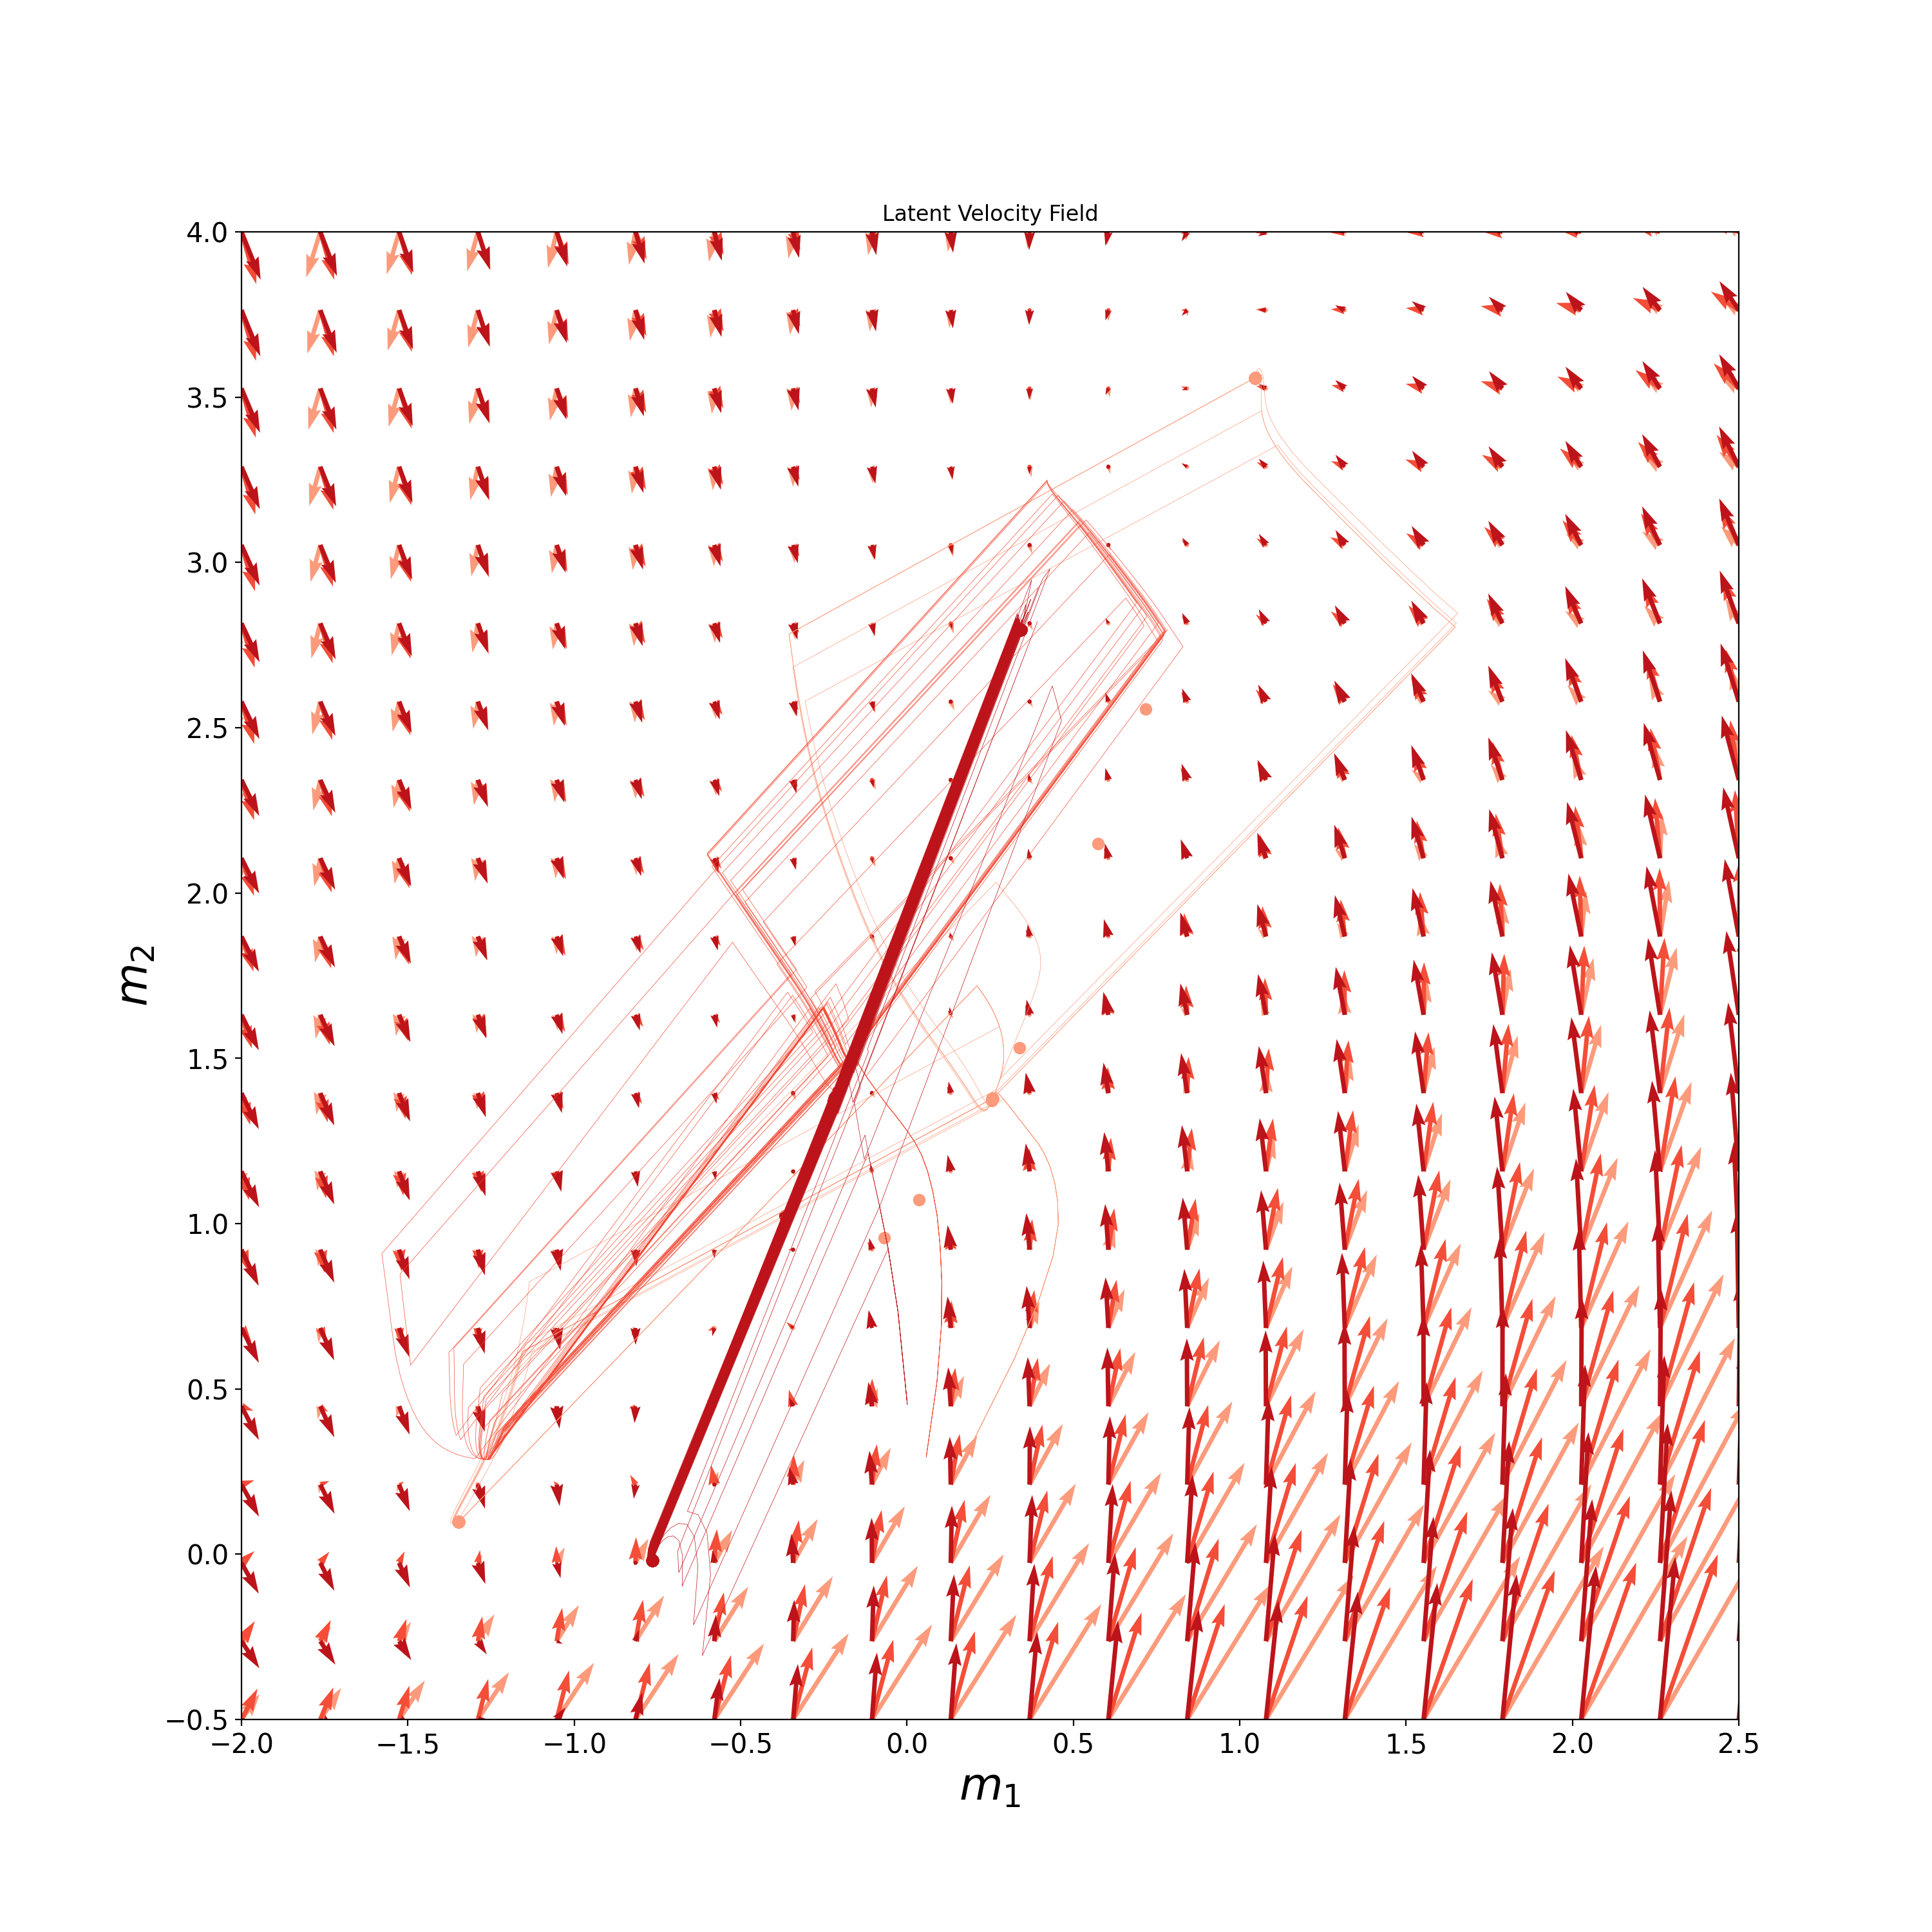

In [89]:
num_points = 20
latents_range = [[-2,2.5], [-.5,4]]
input_field = torch.tensor([[0]])  # every point at the grid calculated with F(0, point)

%matplotlib notebook

plot_velocity_field_non_pca([node_OBS_2D_5, node_OBS_2D, node_OBS_2D_200], 
                            input_field, latents_range, num_points, 
                            xstar=[xstar_5, xstar_20, xstar_200], 
                            q_flag=[q_flag_5, q_flag_20, q_flag_200], 
                            colors=[color_5, color_20, color_200], 
                            num_traj=5, 
                            cmap=plt.cm.viridis, 
                            input_trajectories=None, 
                            scatter_trajectories=False, 
                            multiple_models=True)
                            
    

<IPython.core.display.Javascript object>


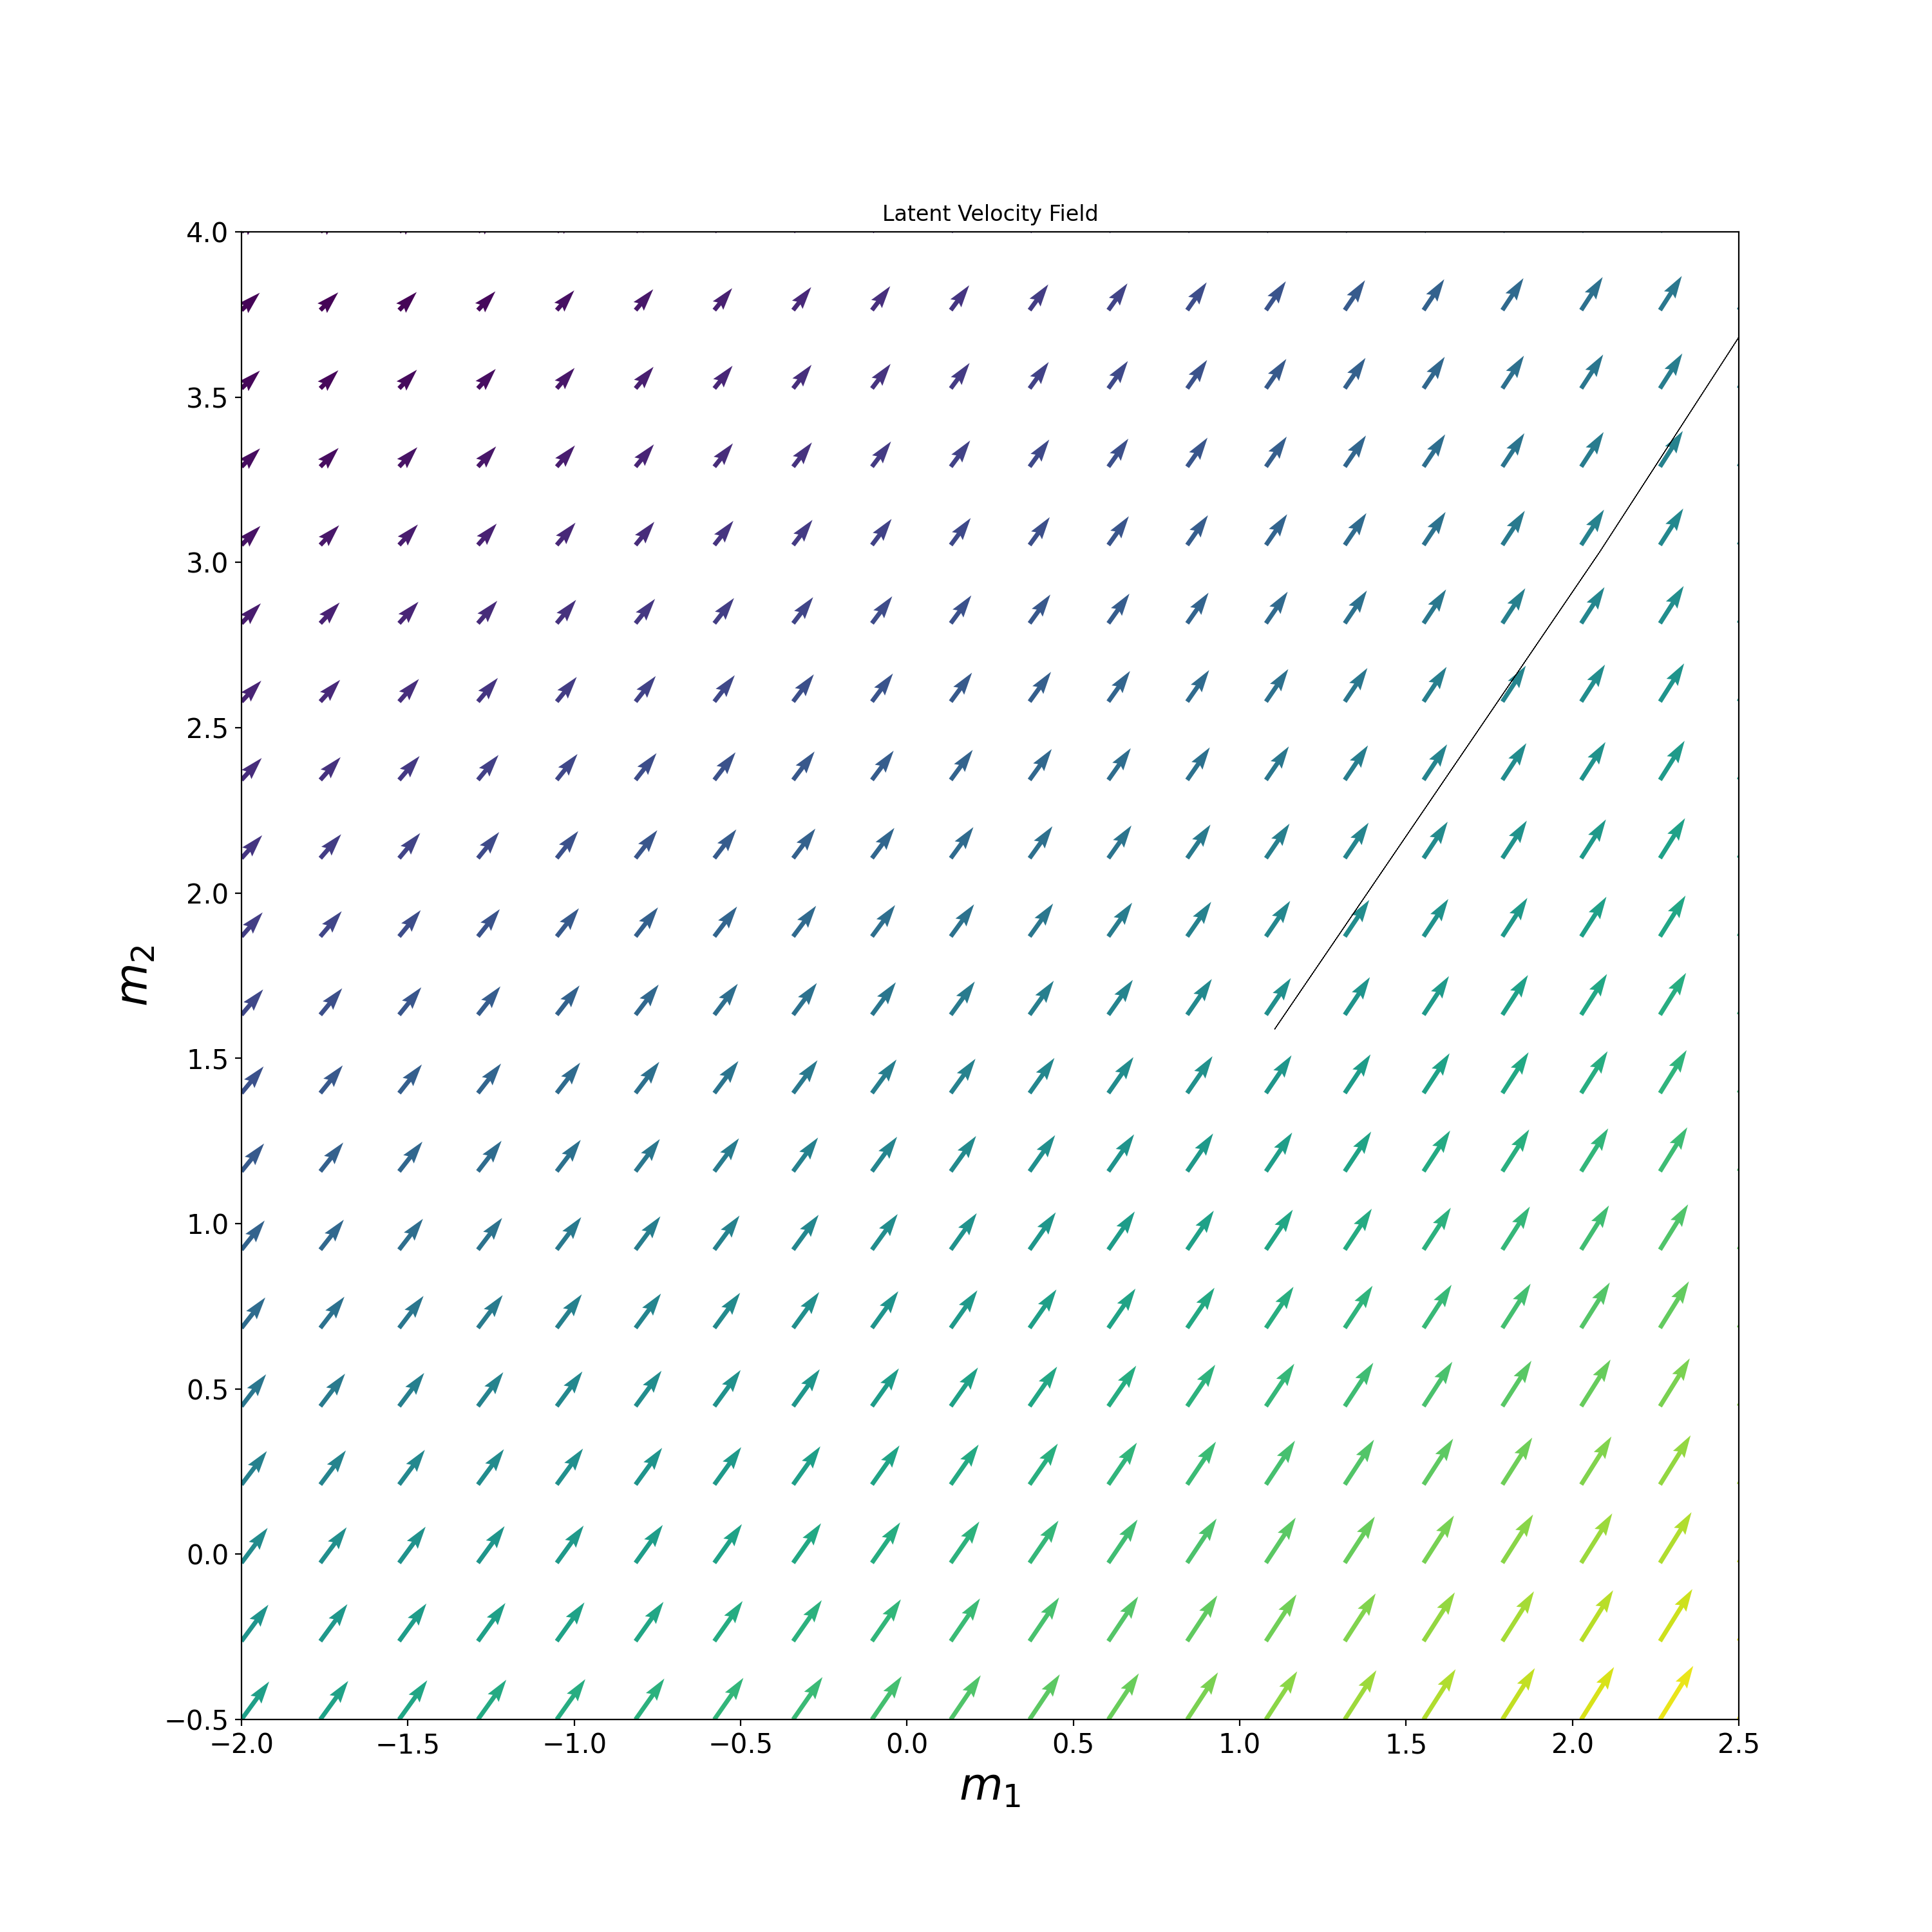

In [15]:
num_points = 20
latents_range = [[-2,2.5], [-.5,4]]
input_field = torch.tensor([[1]])  # every point at the grid calculated with F(0, point)

%matplotlib notebook

plot_velocity_field_non_pca([node_OBS_2D], 
                            input_field, latents_range, num_points, 
                            xstar=[xstar_20], 
                            q_flag=[q_flag_20], 
                            colors=[color_20], 
                            num_traj=20, 
                            cmap=plt.cm.viridis, 
                            input_trajectories=1, 
                            scatter_trajectories=False, 
                            multiple_models=False)

In [ ]:
node_OBS_2D.plot_trial_io_no_pca(num_trials=5, latent_size=2)

In [9]:
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240323_NODE_N3BFF_march23/weight_decay=1e-09 learning_rate=0.001 max_epochs=1500 seed=0 batch_size=256 num_workers=4 n_samples=1000/"
node_3BFF_3D = Analysis_TT(run_name = "node_3BFF3D", filepath = path)

Maximum iteration count reached. Terminating.
Found 10000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


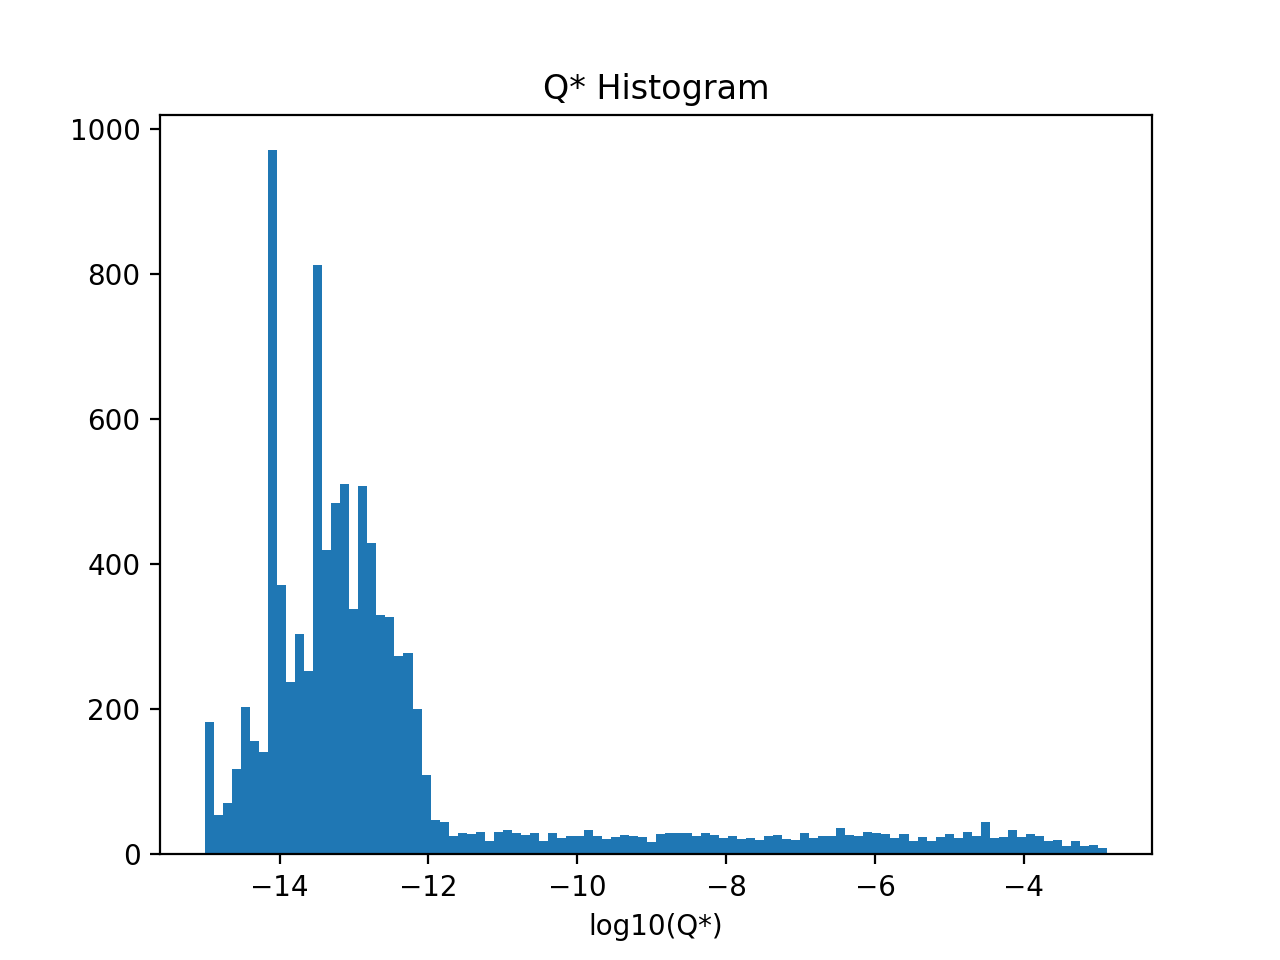

<IPython.core.display.Javascript object>


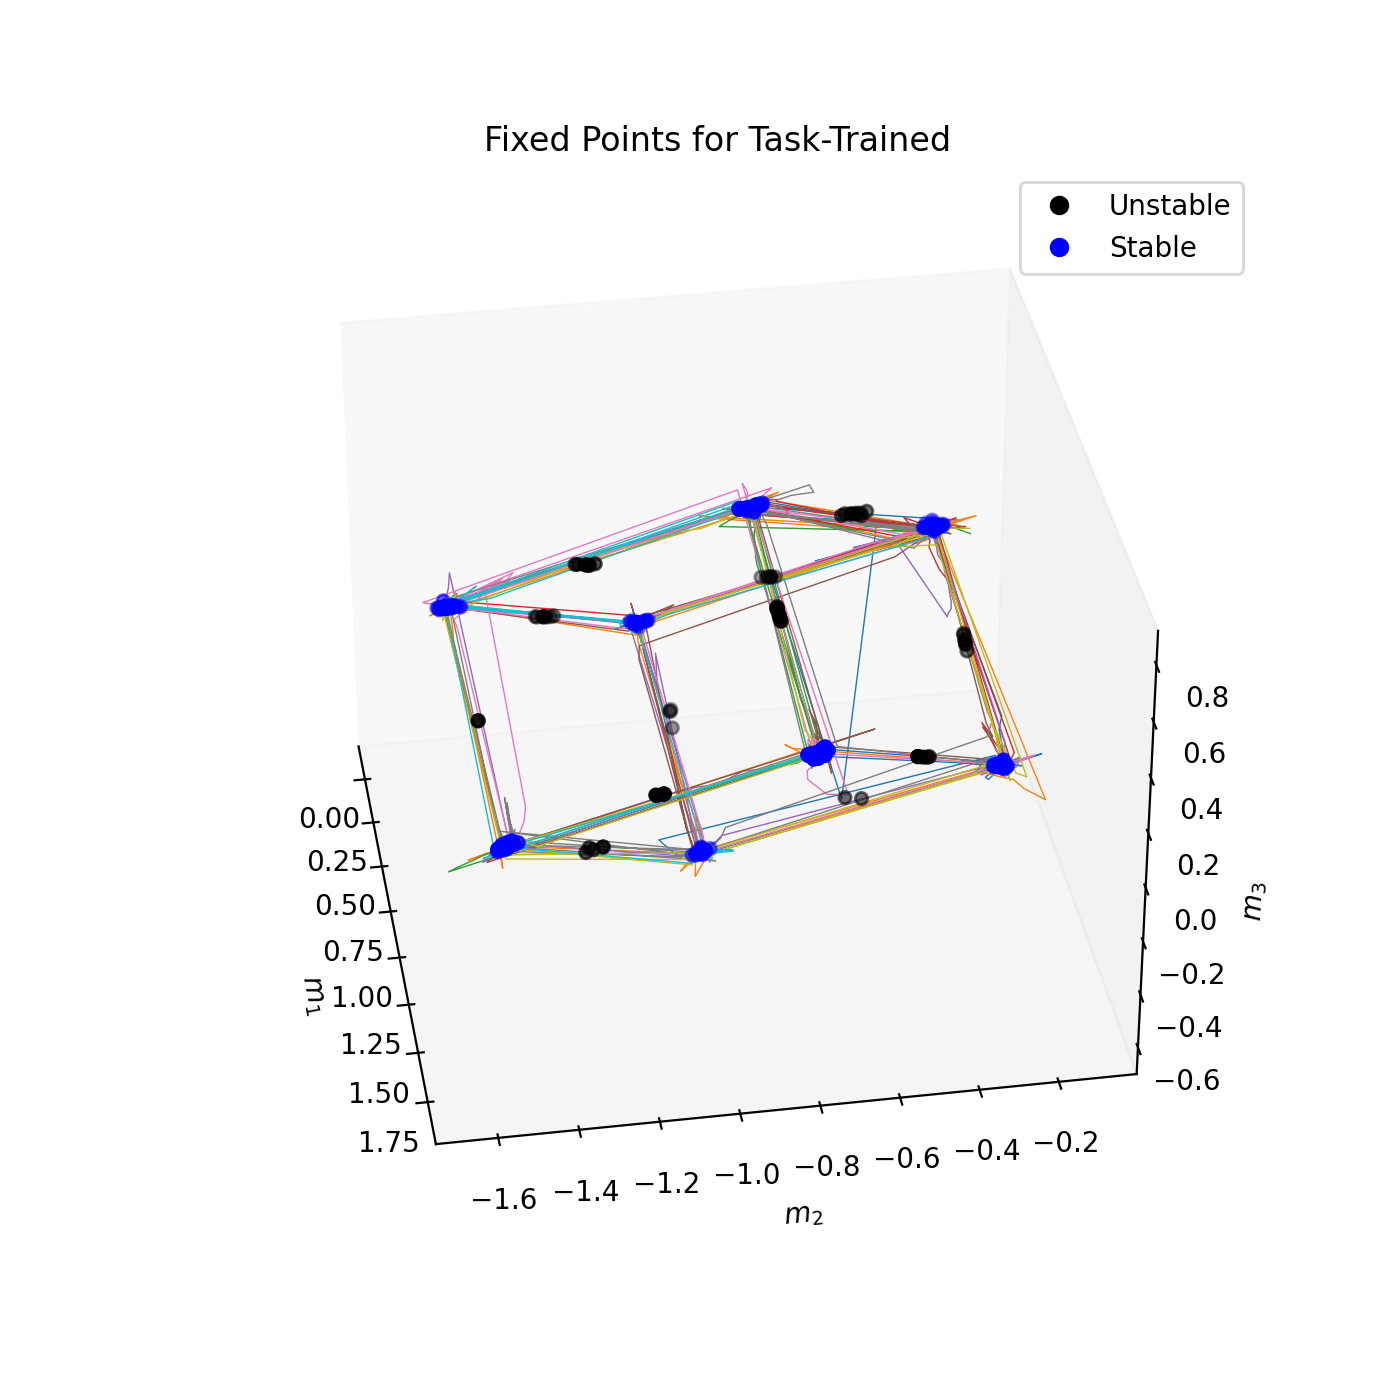

In [3]:
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240323_NODE_N3BFF_march23/weight_decay=1e-09 learning_rate=0.001 max_epochs=1500 seed=0 batch_size=256 num_workers=4 n_samples=1000/"
node_3BFF_3D = Analysis_TT(run_name = "node_3BFF3D", filepath = path)

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,3))
%matplotlib notebook

fps, xstar, q_flag, color = node_3BFF_3D.plot_fps(
    inputs= my_inputs,  #"None" only finds those relevant to the experimental trajs
    n_inits=10000,
    learning_rate=1e-4,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,        # big difference from 1e-3 to 1e-5  - NOTE epsilon used to avoid logs of zeros is 1e-15
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)


<IPython.core.display.Javascript object>


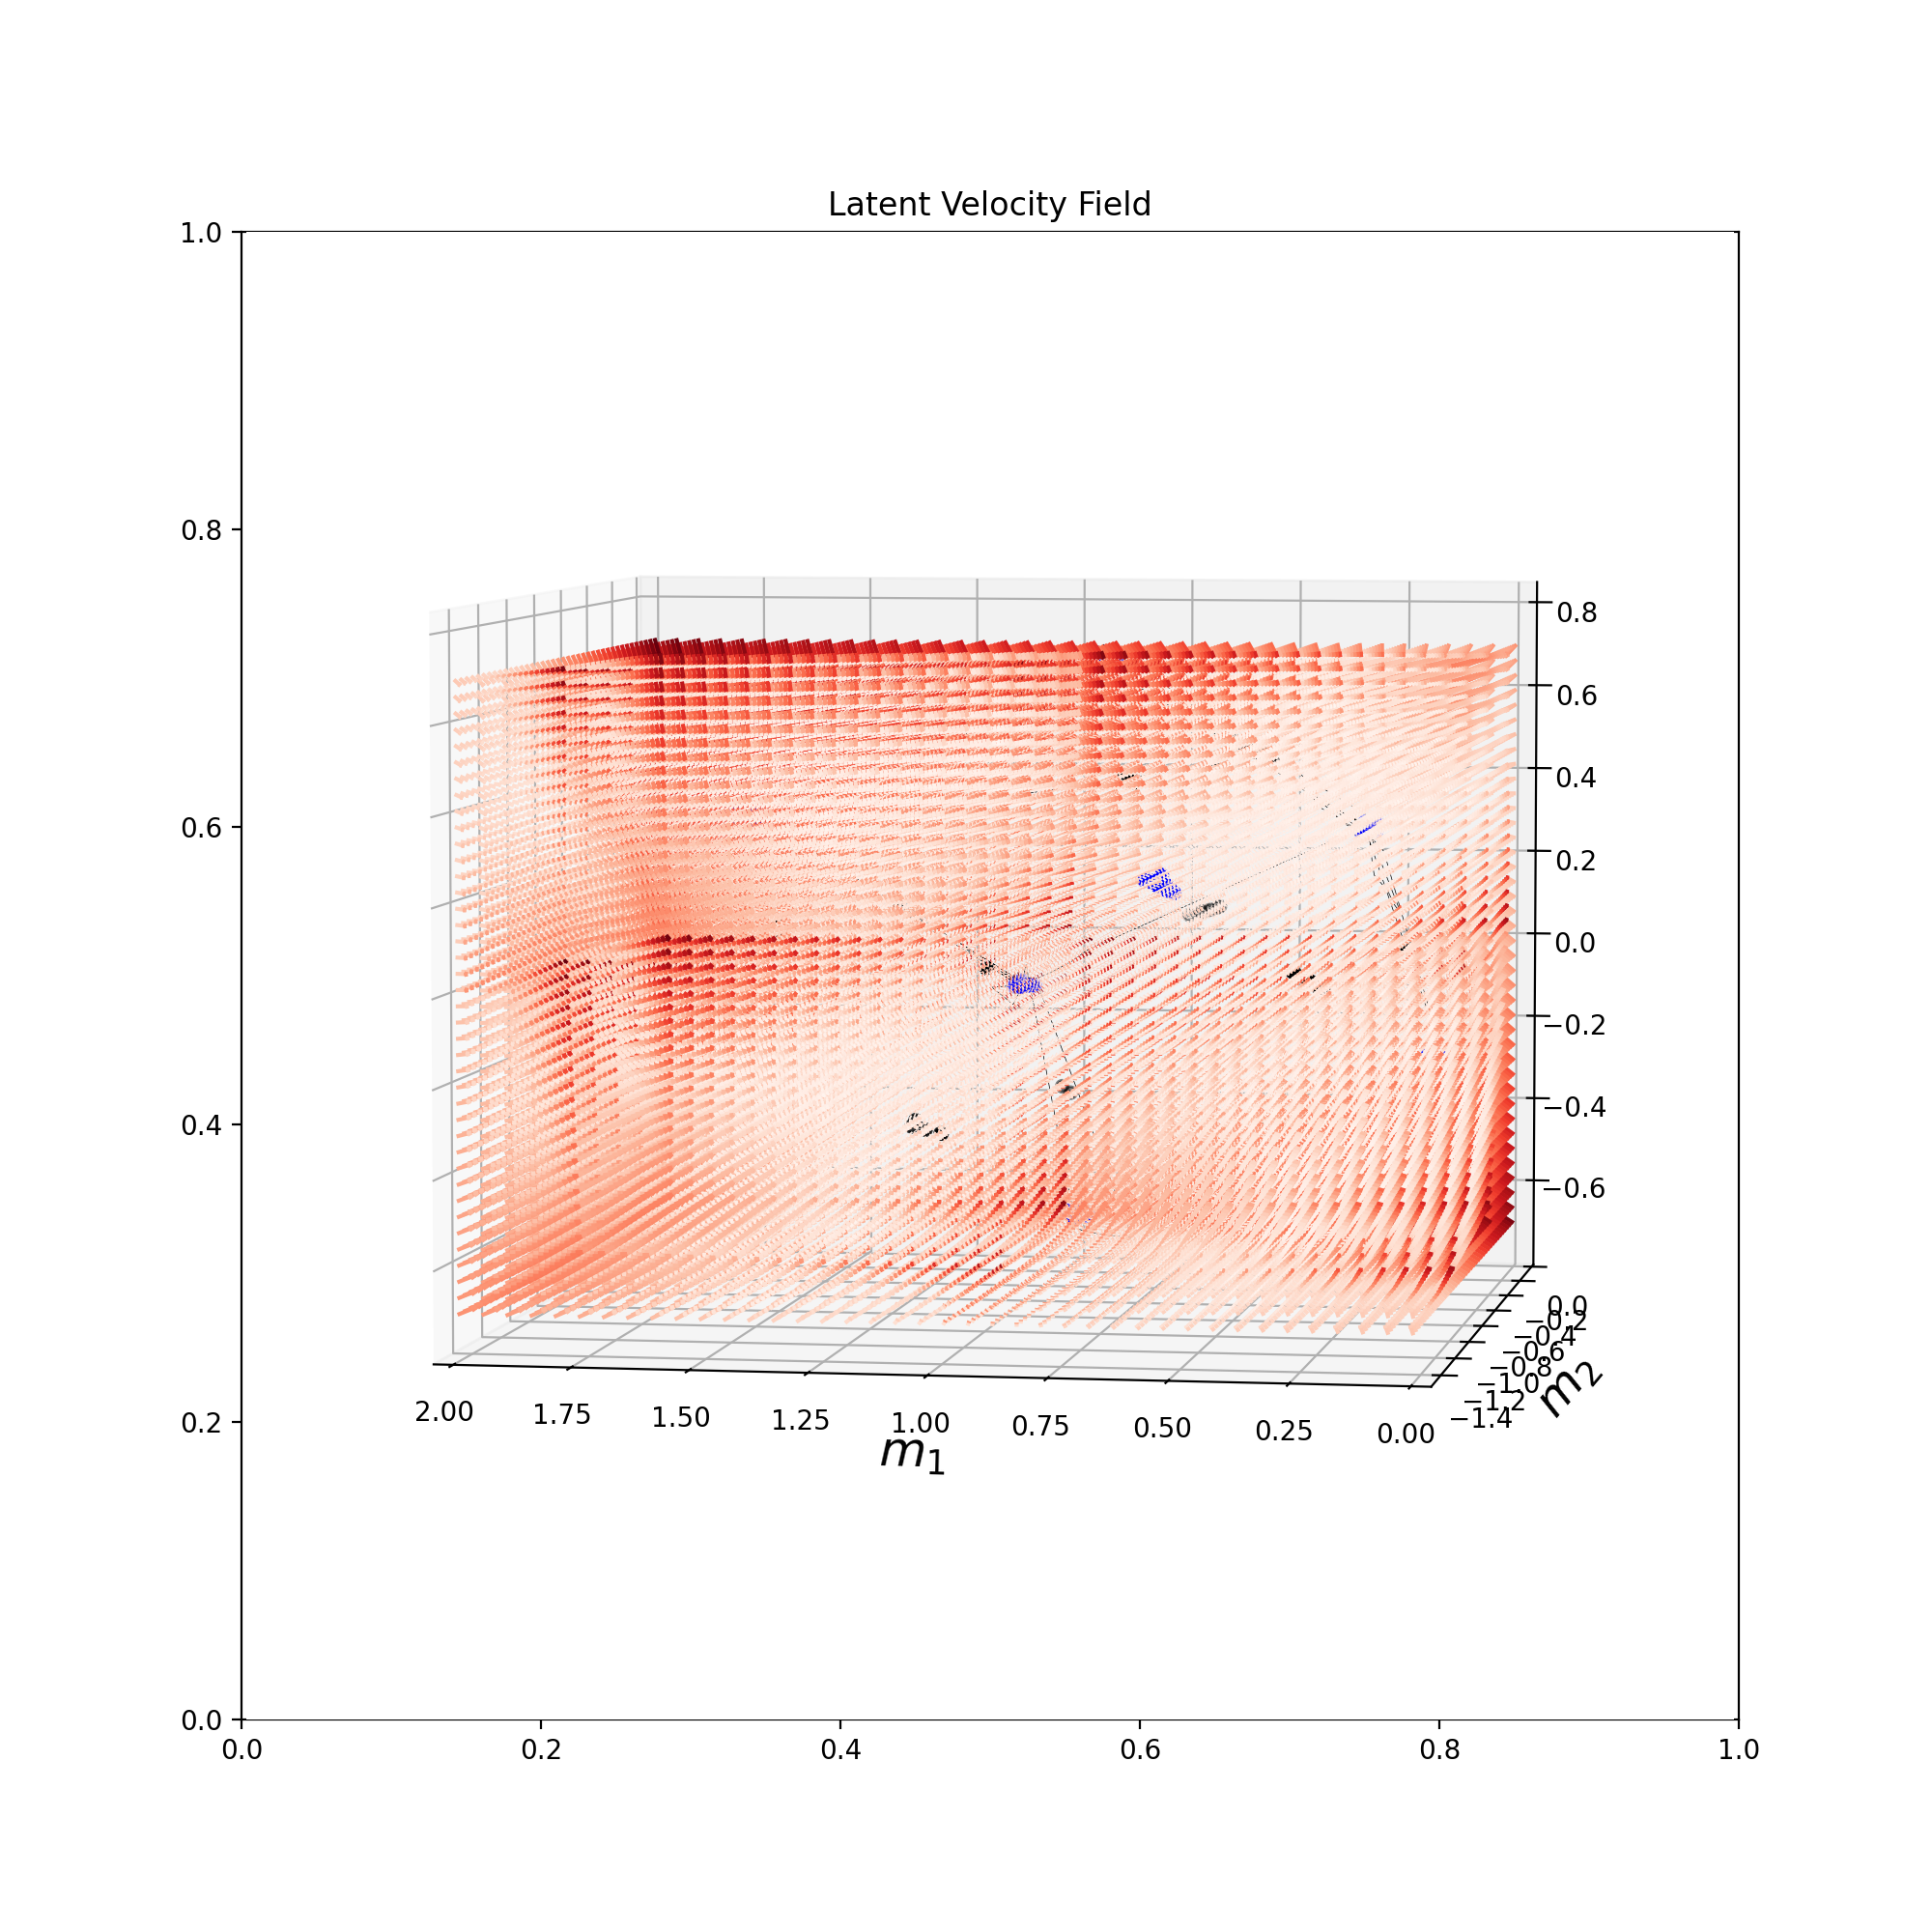

In [9]:
# plot the velocity field
%matplotlib notebook

num_points = 40
latents_range = [[0,2],[0,-1.5],[-0.7,0.7]]
input_field = torch.tensor([[0,0,0]])  # every point at the grid calculated with F(0, point)

plot_velocity_field_non_pca(node_3BFF_3D, input_field, latents_range, num_points, xstar=xstar, q_flag=q_flag, 
                                        colors=color, num_traj=1, cmap=plt.cm.Reds, 
                                        return_animation=False, input_trajectories=0, scatter_trajectories=False)

Maximum iteration count reached. Terminating.
Found 10000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


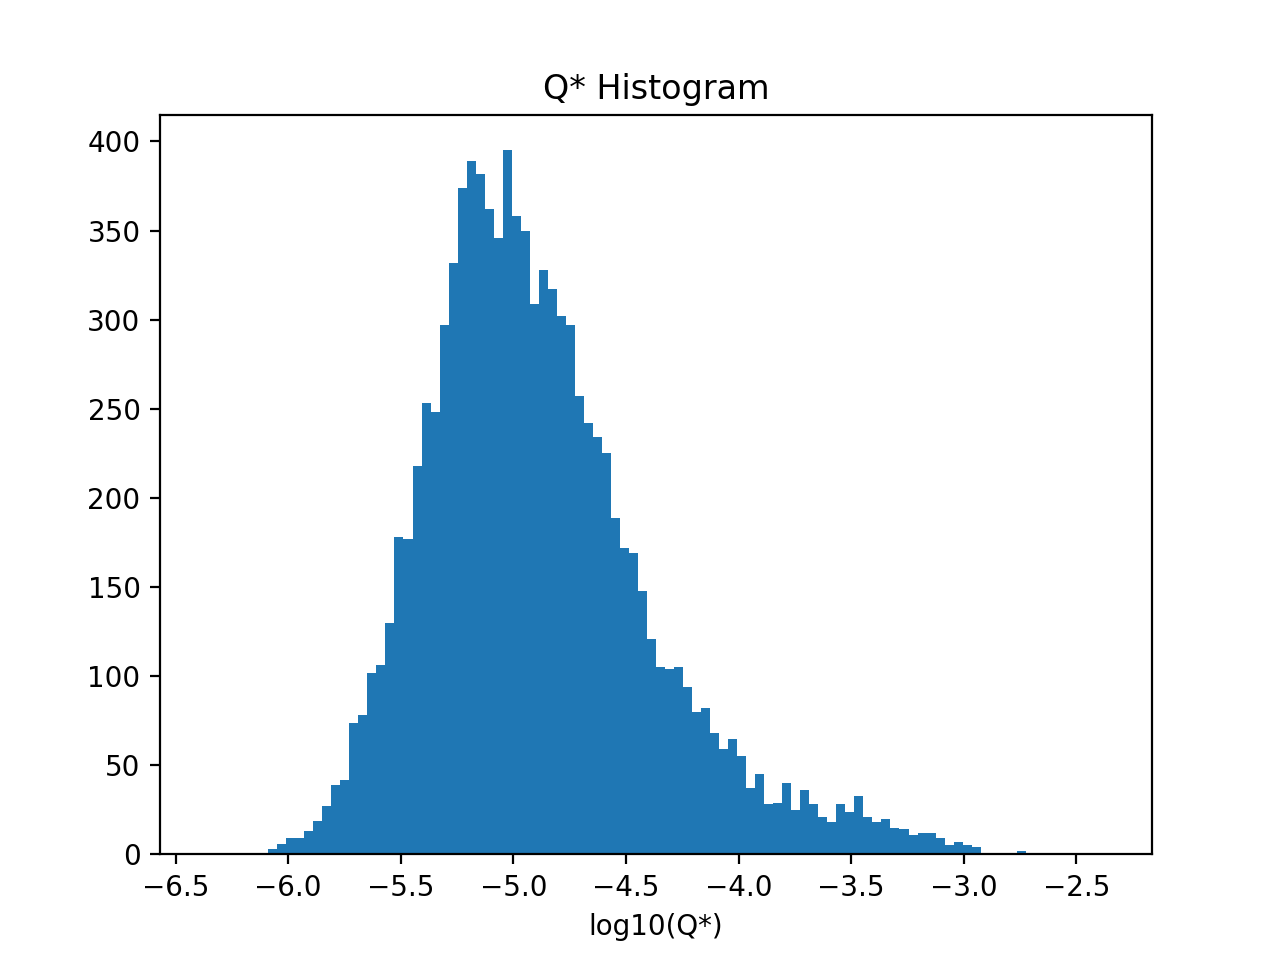

<IPython.core.display.Javascript object>


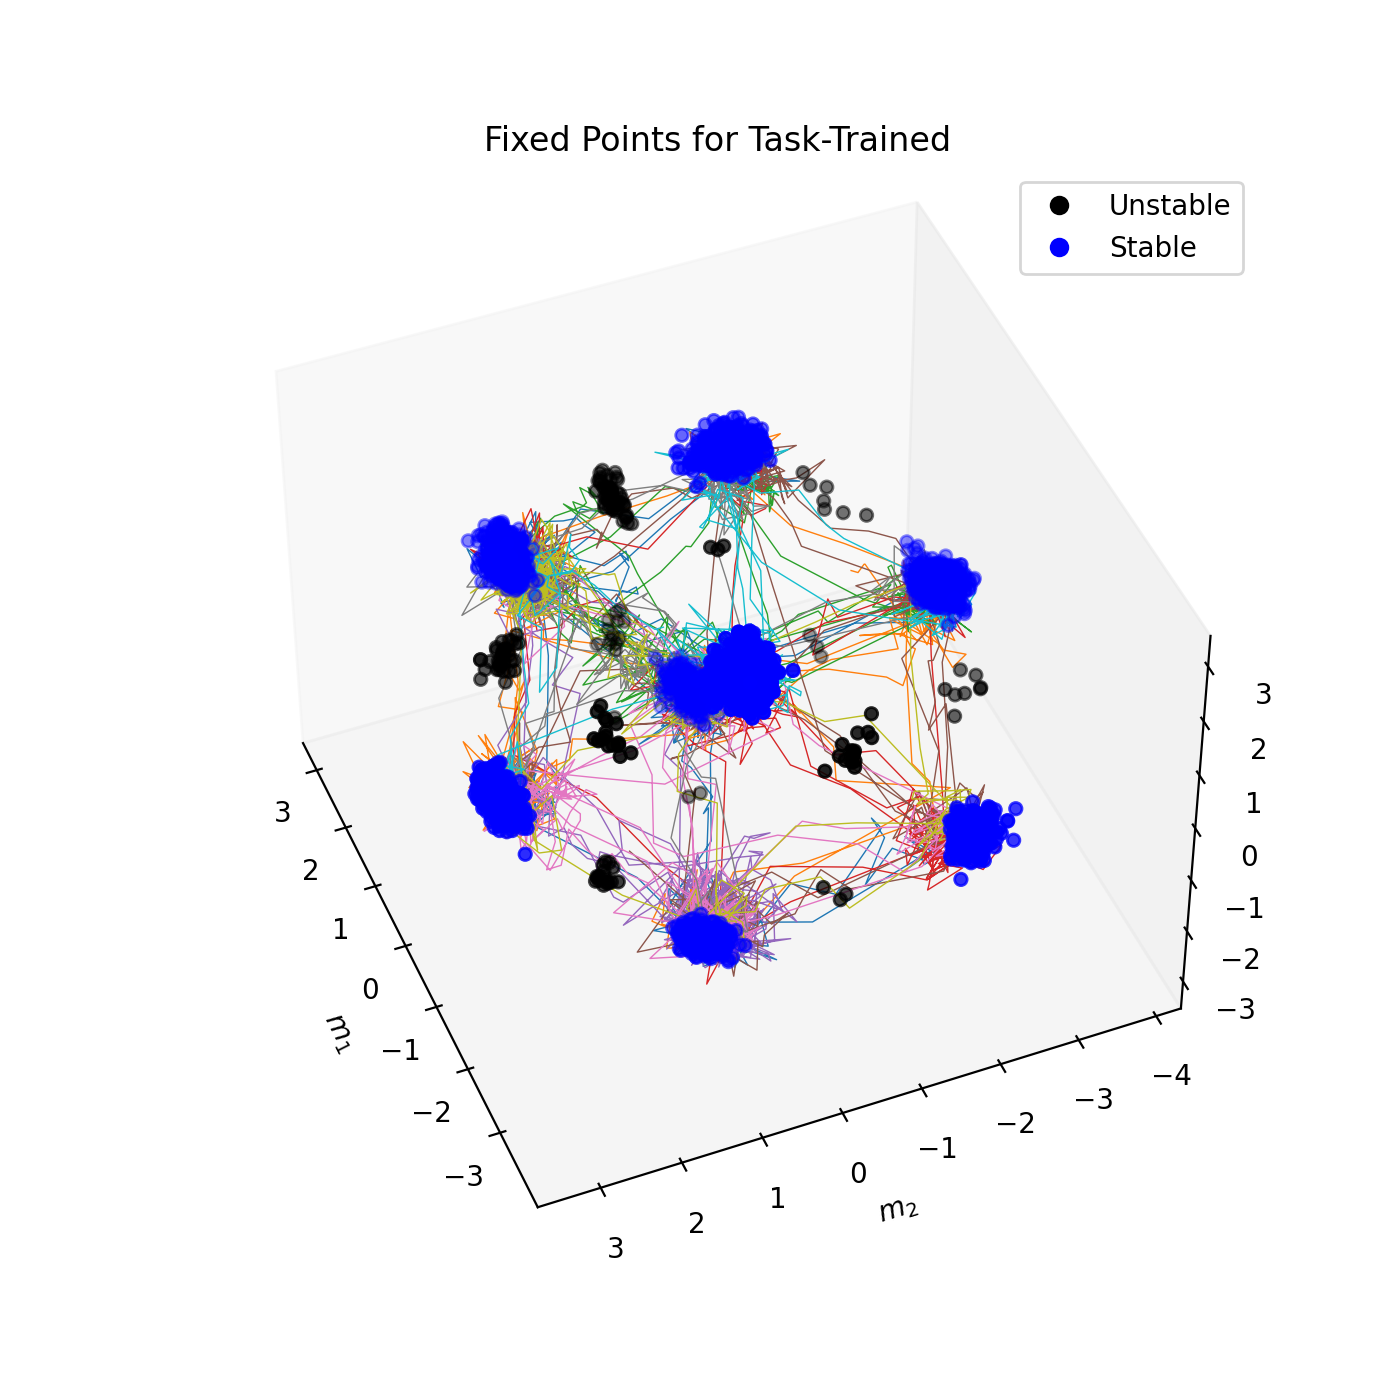

In [4]:


path = "/scratch/network/ad2002/content/trained_models/task-trained/20240429_GRU_3BFF_500epoch/latent_size=64 weight_decay=1e-06 learning_rate=0.001 max_epochs=500 log_every_n_steps=5 seed=0 batch_size=1000 num_workers=1 n_samples=300 n=3 n=3/"

gru_3BFF_3D = Analysis_TT(run_name = "node_3BFF3D", filepath = path)

my_inputs = 1*torch.zeros_like(torch.empty(1000,1000,3))
%matplotlib notebook

fps, xstar, q_flag, color = gru_3BFF_3D.plot_fps(
    inputs= my_inputs,  #"None" only finds those relevant to the experimental trajs
    n_inits=10000,
    learning_rate=1e-2,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-5,        # big difference from 1e-3 to 1e-5  - NOTE epsilon used to avoid logs of zeros is 1e-15
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = True,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
    noiseless=True
)


Maximum iteration count reached. Terminating.
Found 1000 unique fixed points.
Decomposing Jacobians in a single batch.
Sorting by Eigenvalue magnitude.


<IPython.core.display.Javascript object>


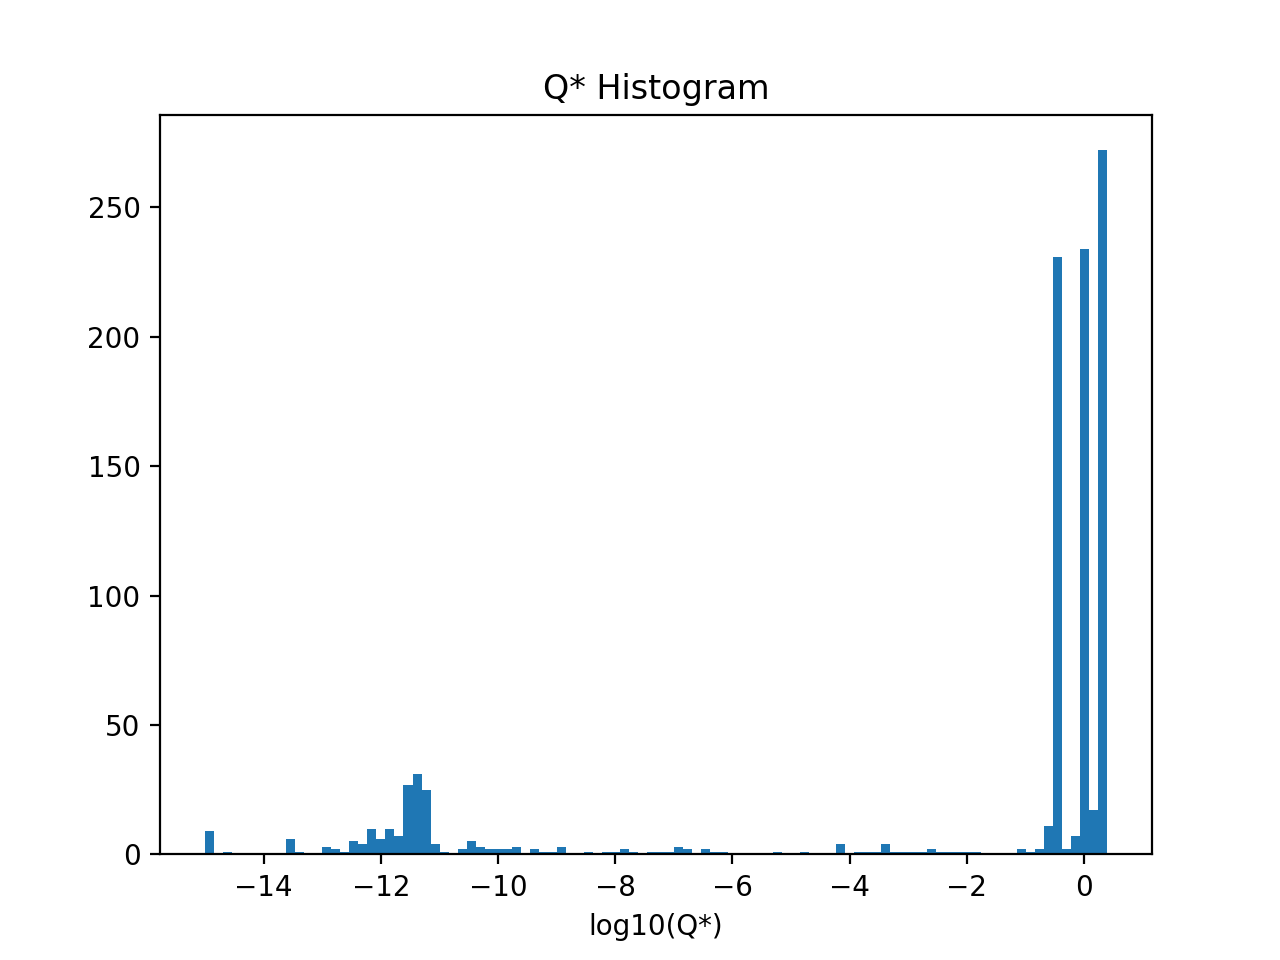

<IPython.core.display.Javascript object>


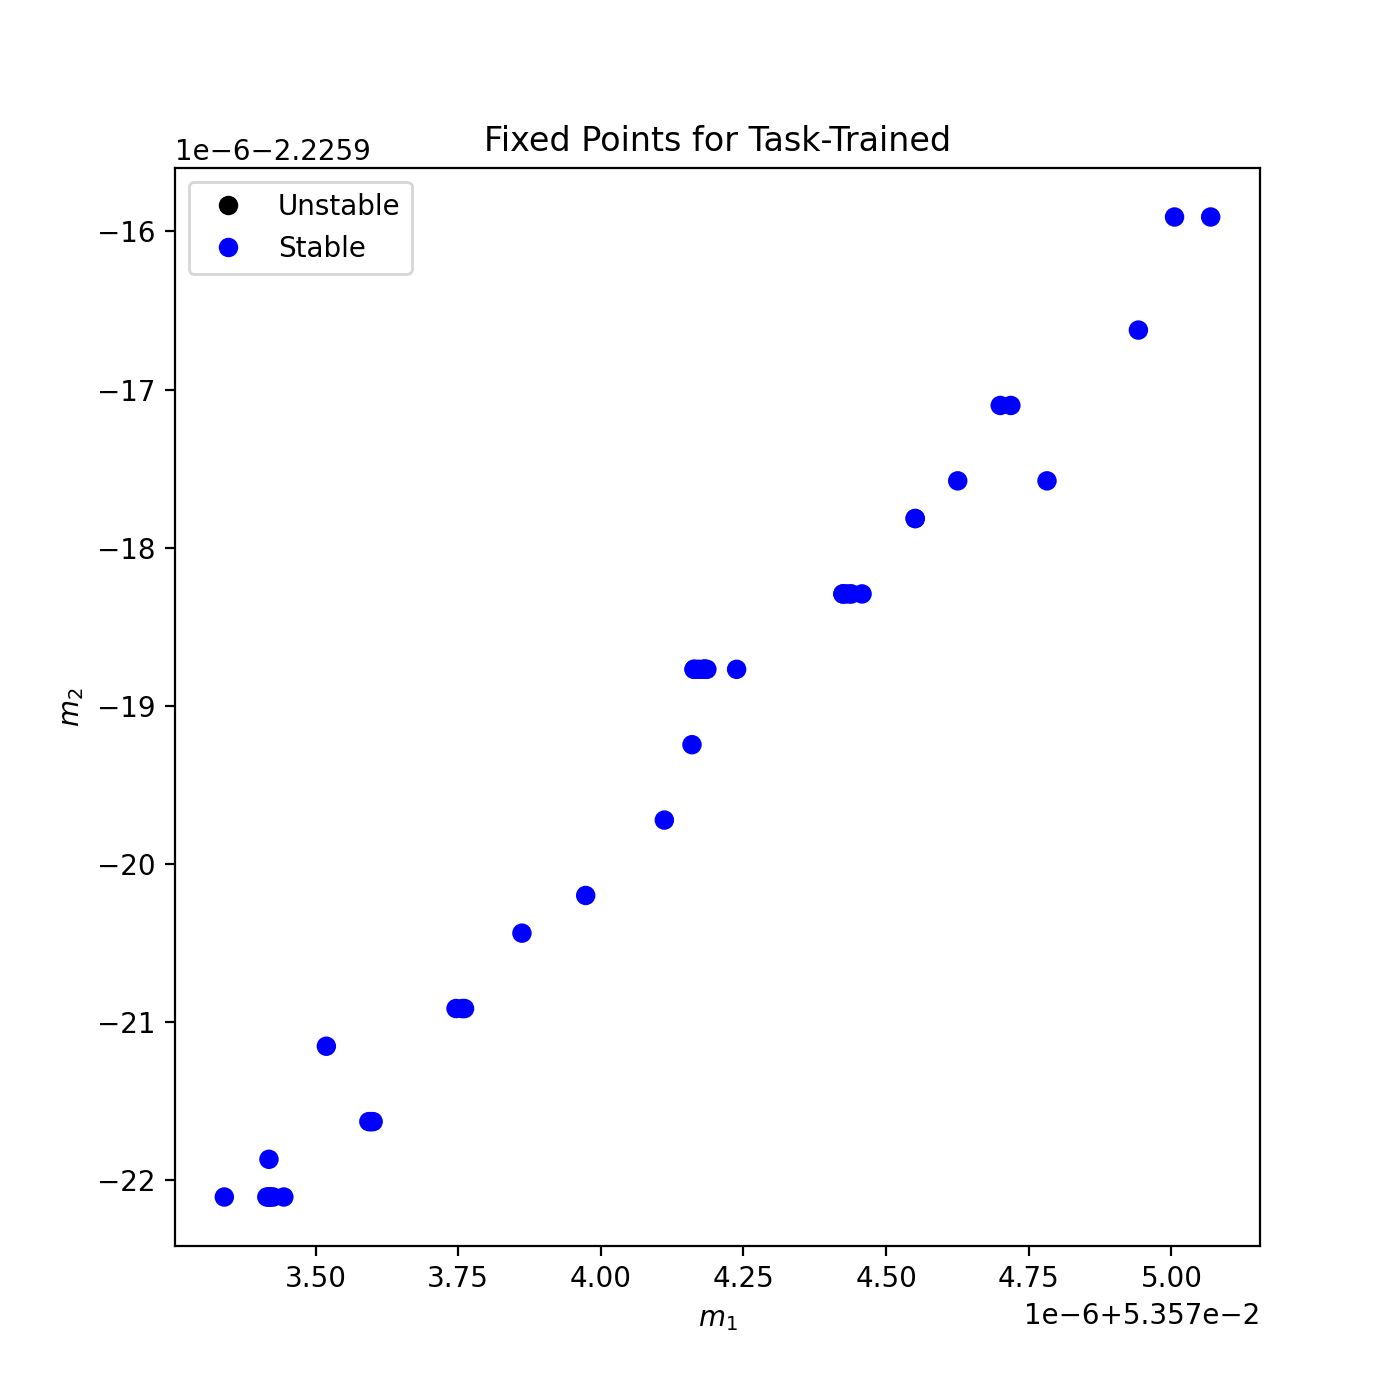

In [11]:
# VERIFY THAT MY VELOCITY FIELD WORKS
path = "/scratch/network/ad2002/content/trained_models/task-trained/FINAL/20240425_NODE_2BFF_400epoch/latent_size=2 weight_decay=1e-05 learning_rate=0.01 max_epochs=400 log_every_n_steps=1 seed=0 batch_size=128 num_workers=1 n_samples=500 n=2 n=2/"
node_2BFF_2D = Analysis_TT(run_name = "node_2bff_known", filepath = path)

my_inputs = 1*torch.ones_like(torch.empty(1000,1000,2))
%matplotlib notebook

fps, xstar, q_flag, color = node_2BFF_2D.plot_fps(
    inputs= my_inputs,  #"None" only finds those relevant to the experimental trajs
    n_inits=1000,
    learning_rate=1e-4,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-12,        # big difference from 1e-3 to 1e-5  - NOTE epsilon used to avoid logs of zeros is 1e-15
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = True,
    report_progress = False,
    return_points = True,
    noiseless=True
)


<IPython.core.display.Javascript object>


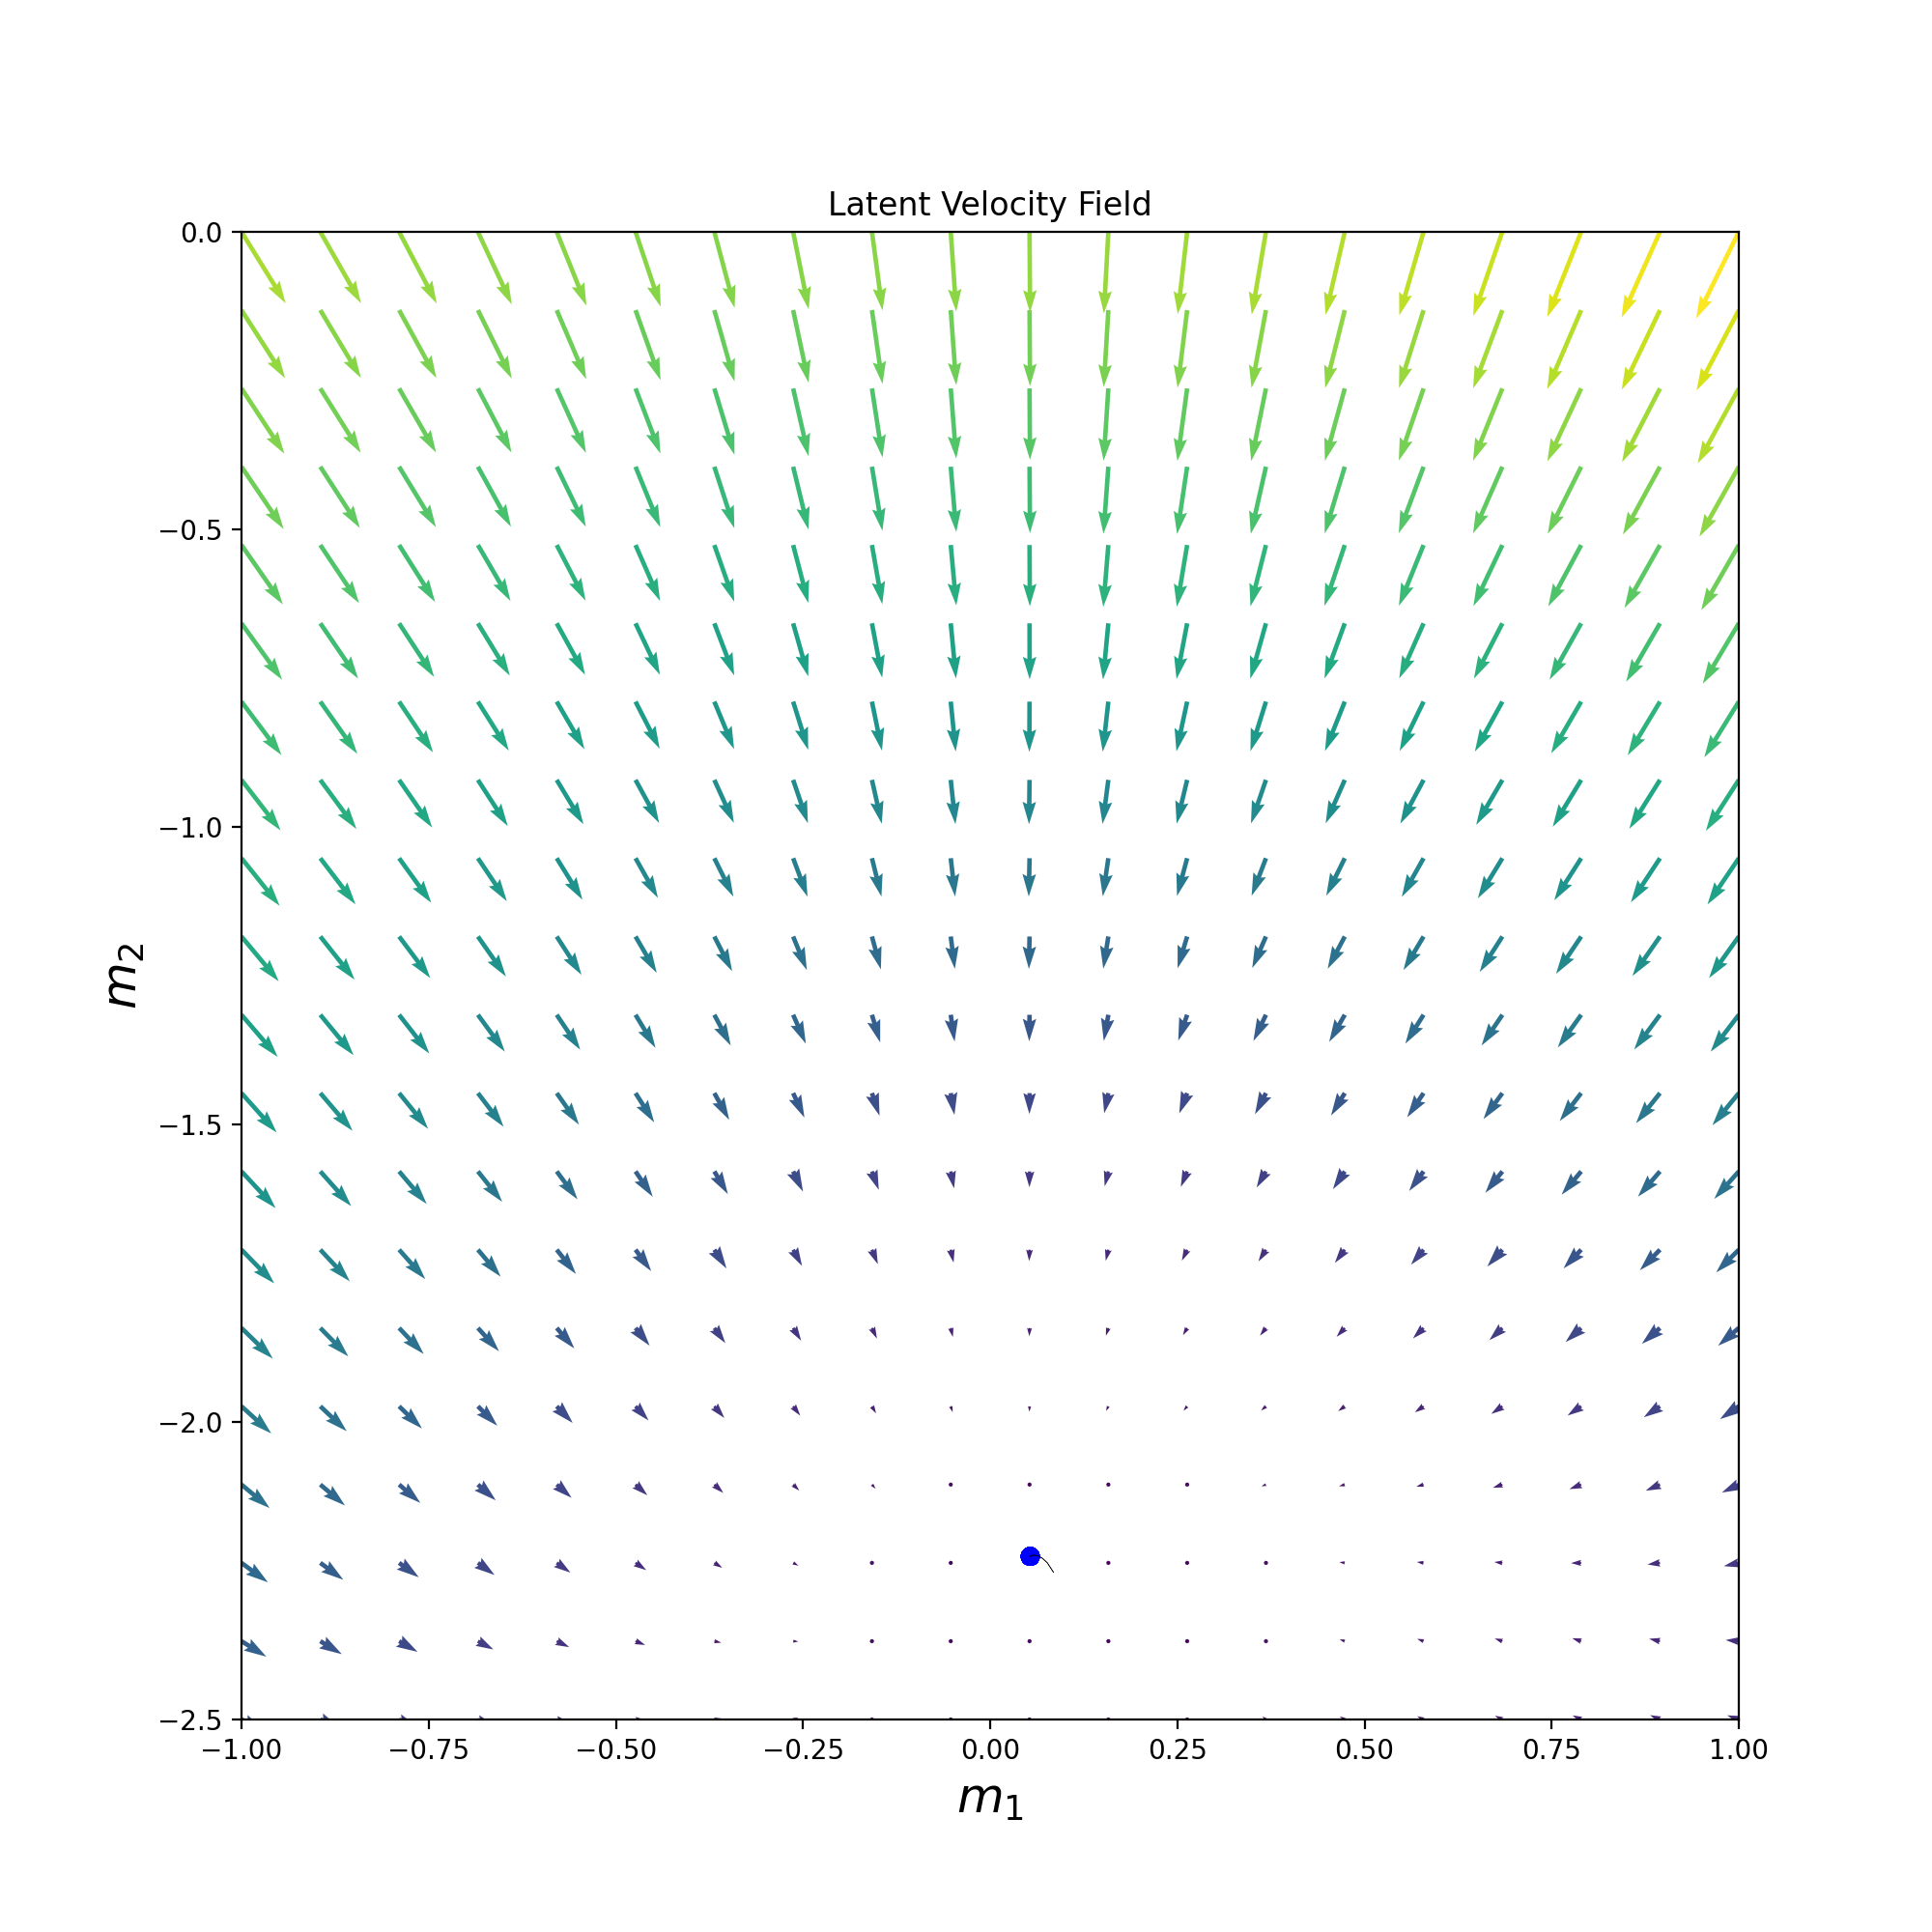

In [17]:
num_points = 20
latents_range = [[-1,1], [-2.5,0]]
input_field = torch.tensor([[1,1]])  # every point at the grid calculated with F(0, point)

plot_velocity_field_non_pca(node_2BFF_2D, input_field, latents_range, num_points, xstar=xstar, q_flag=q_flag, 
                                        colors=color, num_traj=2, cmap=plt.cm.viridis, 
                                        return_animation=False, input_trajectories=1)


In [ ]:
# now for 

### NODE: latent size = 3

* weight decay 1e-10
* learning rate 1e-2
* 300 epochs
* n=20 (average pulses in trial)

In [ ]:
path = "/scratch/network/ad2002/content/trained_models/task-trained/20240422_NODE_OBS3D_300epoch/latent_size=3 layer_hidden_size=100 num_layers=3 weight_decay=1e-10 learning_rate=0.01 max_epochs=300 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS_3D = Analysis_TT(run_name = "node_obs_test", filepath = path)

In [ ]:
node_OBS_3D.plot_trial_io_no_pca(num_trials=5, latent_size=3)

In [ ]:
%matplotlib notebook

my_inputs = torch.zeros_like(torch.empty(1000,1000,1))

fps, xstar, q_flag, color = node_OBS_3D.plot_fps(
    inputs= my_inputs,  
    n_inits=1000,
    learning_rate=1e-7,   # higher rate gives less but actually accurate values
    noise_scale=0,
    max_iters=1000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,        # big difference from 1e-4 to 1e-5
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

In [ ]:
# plot the velocity field
%matplotlib notebook

num_points = 20
latents_range = [[-1.2,-0.3],[-1,0.4],[-1.2,1]]
input_field = torch.tensor([[0]])  # every point at the grid calculated with F(0, point)

plot_velocity_field_non_pca(node_OBS_3D, input_field, latents_range, num_points, xstar=xstar, q_flag=q_flag, 
                                        colors=color, num_traj=1, cmap=plt.cm.Reds, 
                                        return_animation=False, input_trajectories=0, scatter_trajectories=False)

## Hyperparameter tuning for the models

### NODE on 3BFF

In [ ]:
def plot_loss_curves(directory, n_epochs, start_epochs=0):
    
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    for file in csv_files:
        file = directory+file
        # Load the data
        with open(file, 'r') as f:
            data = pd.read_csv(f)
    
        # Fill missing values with the previous ones
        data.ffill(inplace=True)
    
        # Plot validation loss - 300 is max number of epochs shared by the 30+ tune sets
        plt.figure(figsize=(10, 5))
        plt.plot(data['epoch'][start_epochs:n_epochs], data['valid/loss'][start_epochs:n_epochs], label='Test(valid) Loss')
    
        # Plot test loss
        plt.plot(data['epoch'][start_epochs:n_epochs], data['train/loss'][start_epochs:n_epochs], label='Train Loss')
    
        # Extract parameters from the filename
        parameters = file.split(',')  # Change this if your delimiter is not an underscore
        parameters[-1] = parameters[-1].replace('.csv', '')  # Remove the .csv extension from the last parameter
        title = ' '.join(parameters)
    
        plt.title(f'Validation and Test Loss Over Epochs for {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.show()
    

In [ ]:
directory = 'node_3bff_metrics/'
plot_loss_curves(directory, 300)

# OBSERVATIONS
# NODE for 3BFF is clearly NOT overfitting in any case - it might be underfitting - how to tell?

# most optimal of 300: set 21
# latent size 6
# batch 64
# learning 0.001
# weight decay: 

### Vanilla on 3BFF

In [ ]:
directory = 'vanilla_3bff_metrics/'
plot_loss_curves(directory, 300)

# never seems to go below 0.2

### Node on OBS

In [ ]:
directory = 'node_obs_metrics/'
plot_loss_curves(directory, 1500, start_epochs=10)

# maybe set 7 seems the best

In [ ]:
directory = 'gru_obs_metrics/'
plot_loss_curves(directory, 1500, 10)

# interest slow start then drop

# learning rate seems to be the determinant factor for GRU, while the weight decay seems more important for NODE

## PREVIOUS runs: One Bit Sum - OBS

Similar to the PClicks task that rats do in the Brody Lab. We have a train of spikes at constant intervals of time where the cumulative sum lies between a pre-determined range. The output should be the sign of the cumulative sum since t = 0.

### CORRECTION: the results below are not really accurate. The inputs are not sparse and there is no time for memorization - the network oscillates erratically between points and used the immediate dynamics

### NODE: latent size = 2

In [ ]:
# NODE on OBS - worked better for the highest learning rate and lowest weight decay

path = "/scratch/network/ad2002/content/trained_models/task-trained/20240419_NODE_OBS_200epoch_2D/latent_size=2 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.001 max_epochs=200 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS = Analysis_TT(run_name = "node_obs_test", filepath = path)

In [ ]:
# plot dimensions without pca

node_OBS.plot_trial_io_no_pca(num_trials=5, latent_size=2)

In [ ]:
# basically one latent seems to be solving the task (as one could expect...)

node_OBS.plot_trial_io(num_trials=3, n_pca_components=2)

In [ ]:
# plot the fixed points

# higher learning rate and low threshold is the way to go
# NOTE that increasing the inits past 1000 starts to distort the results
# stable points do not seem to reach threshold below 1e-5

# NOTE the networks that could not solve the task have a curve of trajectories outlined by unstable points and 
# ending on some stable ones

fps_OBS, xstar, q_flag, color = node_OBS.plot_fps(
    inputs= None,  
    n_inits=1000,
    learning_rate=1e-4,
    noise_scale=0,
    max_iters=100000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,
    n_pca_components = 2,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

In [ ]:
# shape of inputs is 
node_OBS.explore_params()

num_points = 20
latent_range = [[-2,5], [-2,5]]

# inputs has to match the number of coordinates along the first dimension
# (or match the first 2 directions if passing in trajectories, not single points)
inputs = torch.empty(num_points**2,1)
inputs = -1*torch.ones_like(inputs)

# Define the size of the tensor
size = (num_points**2, 1)

# # Generate a tensor with random integers in the range [0, 2]
# random_integers = torch.randint(0, 3, size)
# values_mapping = torch.tensor([-1, 0, 1])
# inputs = values_mapping[random_integers]

node_OBS.plot_velocity_field_non_pca(inputs, latent_range, num_points, xstar, q_flag, color, num_traj=1)

# 1000 - n_samples from task datamodule_train configs - here I just need 1 sample (this is the number of trials)
# 500 - n_timesteps from env_task configs
# I want 20*20,2

### NODE: latent size = 3

In [ ]:
# NODE on OBS - worked better for the highest learning rate and lowest weight decay

path = "/scratch/network/ad2002/content/trained_models/task-trained/20240421_NODE_OBS_200epoch_3D/latent_size=3 layer_hidden_size=100 num_layers=3 weight_decay=1e-09 learning_rate=0.01 max_epochs=200 log_every_n_steps=2 seed=0 batch_size=256 num_workers=1 n_samples=500/"
node_OBS_3D = Analysis_TT(run_name = "node_obs_test", filepath = path)

In [ ]:
# again all the activity seems to be contained in 1 latents
# MSE ~ 0.001 it solves it better in less time, but surely NODE in 2D can get the same with more epochs

node_OBS_3D.plot_trial_io_no_pca(num_trials=3, latent_size=3)

In [ ]:
fps_OBS_3D, xstar, q_flag, color = node_OBS_3D.plot_fps(
    inputs= None,  
    n_inits=1000,
    learning_rate=1e-3,
    noise_scale=0,
    max_iters=10000,
    seed=0,
    compute_jacobians=True,
    q_thresh=1e-4,
    n_pca_components = 3,
    return_pca_model=False,
    do_pca = False,
    plot_only_points = False,
    report_progress = False,
    return_points = True,
)

In [ ]:
# visualize the structure of the NODE
from ctd.task_modeling.model.node import NODE

# Initialize the model
model = NODE(num_layers=3, layer_hidden_size=128, latent_size=2, output_size=10, input_size=1)
model.init_model(input_size=10, output_size=10)

# Create a dummy input and pass it through the model
inputs = torch.randn(1, 1)
hidden = torch.randn(1, 2)
outputs = model(inputs, hidden)

# Create a diagram of the model
dot = make_dot(outputs, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('network_diagram')